# Industry clustering analysis

This notebook implements the industry clustering analysis carried out [here](http://www.nber.org/papers/w20375). It also contains (towards the end) some exploratory analyses we used in project blogs and in a working paper we are currently developing.

**IMPORTANT OBSERVATION**

This notebook is provisional. Its main purpose currently is to guide the reader/analyst through the analysis we undertook for our industry visualisations in [Arloesiadur](http://www.arloesiadur.org)

Some of the data inputs into the notebook are not publicly available for disclosure reasons, and there are a couple of bugs in the code. We will include suitable data inputs and debug the notebook in due course. Thank you for your patience.


Raw data:

* IDBR Nomis data
* APS data
* Input/output data

Activities:
* ETL
* Extract sector similarity matrices (correlation between sectors)
* Combine similarity matrices (after normalisation).
* Identify industrial clusters.

Outputs
* Collections of SIC codes for an analysis of industrial specialisation in the UK (for Arloesiadur)

## 0. Preamble

In [44]:
#Magic
% matplotlib inline

#Imports
#Directory management
import os
import sys

#Data download
from urllib.request import urlretrieve
from urllib.request import urlopen
import requests
import ratelim
import xlrd
import itertools

#Data processing
import datetime
import re

#Data analysis
import math
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [45]:
#Directories

#Set current dir
cur_dir = os.getcwd()

#Create input data folder, intermediate output folder and output folder

if 'input_data' not in os.listdir():
    os.mkdir('input_data')
if 'intermediate_outputs' not in os.listdir():
    os.mkdir('intermediate_outputs')
if 'outputs' not in os.listdir():
    os.mkdir('outputs')


In [46]:
#Functions (move them up here as you write them)
def create_lq_df(df):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    return(lqs)

def extract_sic_code_aps(x):
    '''
    Input: an integer coding for a SIC
    Output: A string with the right code. If the integer <10000 append it to a zero. Otherwise, remove its last zero
    '''
    
    if x <10000:
        out = "sic_"+'0'+ str(int(x/10))
    else:
        out = "sic_"+str(int(x/10))
    
    return(out)

def process_single_num(x):
    '''
    input: A code in the input output tables
    output: A well formated value for processing
    '''
    
    if (len(x)==1):
        out = '0'+x.strip()
        return(out)
    if (len(x)>2):
        out = re.sub("\\.","",x.strip())
        return(out)
    else:
        return(x)
    
    

## 1. ETL

### Nomis data
#### Tasks
* extract the data and generate location quotients by area; generate correlation matrix.

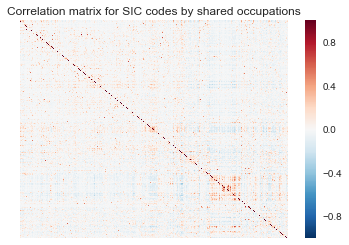

In [47]:
bres_sic_lad = pd.read_csv('../data/interim/bres_sic_lad_proc.csv',na_values="-")

bres_sic_lad.fillna(value=0,inplace=True)
bres_sic_lad = bres_sic_lad.ix[:,2:]


bres_sic_lad = bres_sic_lad.ix[:,[bres_sic_lad.ix[:,x].sum()>0 for x in bres_sic_lad.columns]]

bres_sic_lq = create_lq_df(bres_sic_lad)

bres_sic_mat = bres_sic_lq.corr()

sns.heatmap(bres_sic_mat,xticklabels=False,yticklabels=False)

plt.title("Correlation matrix for SIC codes by shared occupations")
#plt.savefig("outputs/aps_cor_mat.pdf")



In [49]:
bres_sic_lad = pd.read_csv("../data/external/bres_lad.csv",skiprows=8,header=0)
bres_sic_lad.head()


bres_sic_lad = bres_sic_lad.ix[:,[x for x in bres_sic_lad.columns if 'Unnamed' not in x]]
bres_sic_lad.tail(n=10)
#bres_sic_lad.shape

#idbr_sic_lad.head()

bres_sic_lad = bres_sic_lad.ix[:379,:]

'/Users/jmateosgarcia/Desktop/projects_2016/arloesiadur_new/arloesiadur_complexity/notebooks'

In [53]:
#Data downloaded from Nomis using the query builder. 
#TODO: Construct an analogous API call (limit is 25000 cells so it requires several calls)

idbr_sic_lad = pd.read_csv("../data/external/idbr_sic_lad.csv",skiprows=8,header=0)

#Some observations: 
#Rows are LADs, Columns are business counts by 4-digit SICs.
#This contains info for all local authority district/4-digit SIC combinations.
#All numbers are rounded to the closest 5.
#We can do a rowSum to get total number of businesses in an area, but this will be (slightly) distorted by rounding and 
    #removal of sectors with little activity. TODO: Download business count at a more aggregate level (e.g. broad industry groups)
#There are some comments to remove at the end of the table.

#Drop them.
idbr_sic_lad = idbr_sic_lad.ix[:405,:]

In [54]:
#Get business totals by city and by sector

#City
city_biz_counts = pd.concat([idbr_sic_lad.ix[:,0],idbr_sic_lad.ix[:,2:].sum(axis=1)],axis=1)
print(city_biz_counts.sort(columns=0,ascending=False)[:10])

#Write out city business counts to use in other normalisations
city_biz_counts.to_csv("intermediate_outputs/city_biz_counts.csv",index=False)

print("There are {x} areas with no activity".format(x=sum([x==0 for x in city_biz_counts[0]])))

#Sector
sector_counts = pd.DataFrame(idbr_sic_lad.ix[:,2:].sum(axis=0))
print(sector_counts.sort(columns=0,ascending=False)[:10])
print(" ")
print("There are {x} sectors with no activity".format(x=sum([x==0 for x in sector_counts[0]])))


    local authority: district / unitary (prior to April 2015)        0
202                                        Westminster         45935.0
129                                         Birmingham         29480.0
70                                               Leeds         26215.0
189                                             Camden         25545.0
292                                           Cornwall         22840.0
300                                          Wiltshire         21495.0
204                                             Barnet         20790.0
14                                       Cheshire East         18420.0
196                                            Lambeth         17530.0
359                                 Edinburgh, City of         17210.0
There are 0 areas with no activity
                                                           0
7022 : Business and other management consultanc...  153425.0
6202 : Computer consultancy activities               90560.0
8

/Users/jmateosgarcia/.virtualenvs/compl/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/jmateosgarcia/.virtualenvs/compl/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [56]:
#Produce location quotients: for each column: divide the column by its sum, and then divide this 
    #by the ratio of the rowsum in the colsum of the rowSum.    
#Local shares to divide each column by.
local_shares = city_biz_counts[0]/np.sum(city_biz_counts[0])    

#This matrix could be used to measure diversity in Hidalgo's framework.
sic_lqs = idbr_sic_lad.ix[:,2:].apply(lambda x: (x/x.sum()/local_shares),axis=0)
sic_lqs.fillna(value=0,inplace=True)

#Correlation matrix
#Remove sectors with no activity
some_act = [x>0 for x in sector_counts[0]]

sic_lqs_active = sic_lqs.iloc[:,some_act]

sic_cor_mat = sic_lqs_active.corr()
#sns.heatmap(sic_cor_mat,xticklabels=False,yticklabels=False)

#plt.title("Correlation matrix for SIC codes by LAD")
#plt.savefig("outputs/sic_cor_mat.pdf")


In [ ]:
#TODO: I will need to tidy up the data. In particular, extract 4-digit SIC indices from the long names. This is one
#to do later, once I have extracted all the datasets and decided what convention to go for.

### APS data

### Tasks
* Load the data
* Extract SOC counts by 4-digit SIC and generate location quotients (share of occ in sector compared to share of population).
* Produce correlation matrix


In [57]:
#The APS dataset is very wide. We are only interested in a small number of dimensions:
    #soc, sic, weight, activity. Load those.

#Read a subset of the data
aps_test = pd.read_csv("../data/external/APSP_JD14_Nestav2.csv",nrows=5)

#Get column names
columns_lower = list(aps_test.columns.str.lower())

#Get relevant columns and their indices
rel_vars = ["inecac05","indsc07m","soc10m","pwta14"]
var_indices = [columns_lower.index(x) for x in rel_vars]

#Load all the APS data
aps_2014 = pd.read_csv('../data/external/APSP_JD14_Nestav2.csv',usecols=var_indices,na_values=[-9,-8])

In [58]:
#Clean, select data, produce readable var names
aps_workers = aps_2014[[x in [1,2] for x in aps_2014.INECAC05]]
aps_workers.dropna(inplace=True)
aps_workers.rename(columns={x:y for x,y in zip(list(aps_workers.columns),
                                               ['industry','activity','weight','occup'])},inplace=True)

#We need to process the SIC codes (which have been read as 5-digit integers)

aps_workers.industry = aps_workers.industry.apply(lambda x: extract_sic_code_aps(x))

#Need to group by SIC/SOC pairs and produce sums.
#NB here we are not considering lack of stability potentially caused by small sample sizes.
#We could try to address this by averaging over different APSs, or doing counts of cells with combinations of
    #SIC/SOC and dropping those that have small values.
aps_sic_soc = aps_workers.groupby(['industry','occup'])['weight'].sum()

#Create dataframe and pivot for matrix.
aps_sic_soc_df = aps_sic_soc.reset_index(drop=False)

aps_sic_soc_wide = pd.pivot_table(aps_sic_soc_df,index='occup',columns='industry',values='weight',fill_value=0)

#Calculate lqs. It measures the share of an occupation in an industry compared with its importance in the
#economy. How over-represented is the occupation in the industry?

aps_lqs = create_lq_df(aps_sic_soc_wide)

#Create correlation matrix and plot
aps_cor_mat = aps_lqs.corr()

#sns.heatmap(aps_cor_mat,xticklabels=False,yticklabels=False)

#plt.title("Correlation matrix for SIC codes by shared occupations")
#plt.savefig("outputs/aps_cor_mat.pdf")


/Users/jmateosgarcia/.virtualenvs/compl/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/jmateosgarcia/.virtualenvs/compl/lib/python3.5/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/Users/jmateosgarcia/.virtualenvs/compl/lib/python3.5/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

### Input / Output data
#### Tasks
* Download data
* Load. This should be easy.

In [59]:
#Url from the ONS website
url = "http://www.ons.gov.uk/file?uri=/economy/nationalaccounts/supplyandusetables/datasets/inputoutputsupplyandusetables/current/webtables105bb16tables14final.xls"

#Extract data
resp = requests.get(url)
with open('../data/external/i_ot.xls', 'wb') as output:
    output.write(resp.content)

#Load into a dataframe
io_df = pd.read_excel("../data/external/i_ot.xls",sheetname='Table 2 - Int Con 2014',skiprows=3)
#io_df.fillna(value=0,inplace=True)

In [61]:
#Convert into matrix.
#Convert SIC digits into index
io_df2 = io_df.set_index(io_df.columns[0],drop=True)

#Drop string columns
io_df2 = io_df2.ix[1:,1:]

#Drop last columns and rows (totals)
io_df2 = io_df2.iloc[:,['Unnamed' not in x for x in io_df2.columns]]
io_df2 = io_df2.iloc[[str(i)!='nan' for i in io_df2.index],:]

#Plot
#Change type
io_df2 = io_df2.astype(float)
#io_df.fillna(value=0,inplace=True)

#We will use the same approach as Delgado: for each pair of industries, select the maximum share of 
    #consumption in each other's output.
io_df2_shares = io_df2.apply(lambda x: x/x.sum())

io_df_final = pd.DataFrame(index=io_df2_shares.index,columns=io_df2_shares.columns)
io_df_final.fillna(value=0,inplace=True)

#Do it with this loop.
for i in range(0,len(io_df2_shares)-1):
    for j in range(0,len(io_df2_shares)-1):
        v1 = io_df2_shares.ix[i,j]
        v2 = io_df2_shares.ix[j,i]
        
        val = np.max([v1,v2])
        
        io_df_final.ix[i,j]=val
        io_df_final.ix[j,i]=val
    
    

#sns.heatmap(io_df_final,xticklabels=False,yticklabels=False)
#plt.title('Correlation matrix for SIC divisions')

## 2. Merging
#### Tasks:
* We need three matrices with the same dimensions and codes. We will focus on the intersection of sic_cor_mat (the matrix based on co-locations, and aps_cor_mat, the matrix based on shared occupations.

In [77]:
#Change indices and columns in SIC and APS matrices
idbr_sim_mat = sic_cor_mat.copy()
aps_sim_mat = aps_cor_mat.copy()


idbr_sim_mat.index = [x[:4] for x in idbr_sim_mat.index]
idbr_sim_mat.columns = [x[:4] for x in idbr_sim_mat.columns]

aps_sim_mat.index = [x.split("_")[1] for x in aps_sim_mat.index]
aps_sim_mat.columns = [x.split("_")[1] for x in aps_sim_mat.columns]

#Subset them by the shared SIC codes
shared_sics = sorted(list(set(aps_sim_mat.index) & set(idbr_sim_mat.index)))

#Subset both matrices
idbr_sim_mat = idbr_sim_mat[shared_sics]
idbr_sim_mat = idbr_sim_mat.iloc[[x in shared_sics for x in idbr_sim_mat.index],:]

aps_sim_mat = aps_sim_mat[shared_sics]
aps_sim_mat = aps_sim_mat.iloc[[x in shared_sics for x in aps_sim_mat.index],:]

In [78]:
#We also need to process the third matrix (based on trade)
#Strategy: melt the matrix, merge it with the shared indices, and pivot.
#Unfortunately, this requires tidying up the columns in the io table as well.

sics_for_io = pd.DataFrame({'sics':shared_sics})
#sics_for_io


In [79]:
#Read the edited version of code names
codes_cleaned = pd.read_csv("../data/interim/divisions.csv")

#Melt to facilitate merging
io_df3 = io_df_final.copy()

io_df3.fillna(value=0,inplace=True)
io_df3.index = codes_cleaned.ix[:,1]
io_df3.index.rename('code',inplace=True)

io_df3.reset_index(drop=False,inplace=True)
melted_io = pd.melt(io_df3, id_vars ='code')

#Transform into a list
process_list = [[x,y,z] for x,y,z in zip(melted_io['code'],
                                         melted_io['variable'],
                                         melted_io['value'])]


In [80]:
#Need to pre-process all the info in the input-output before merging

processed_list =[]

for i in range(0,len(process_list)):
    #Input the code
    code_input = process_list[i]
    code_var = code_input[0]
    #print(code_var)
    
    #Are there any &s?
    if bool(re.search("&",code_var))==True:
        offspawn = code_var.split("&")
        
        for i in offspawn:
            
            #Are there any -s?
            if bool(re.search("-",i))==True:
                
                #Split by them
                offspawn_2 = i.split("-")
                
                #Recreate numbers in the series by creating a template based on the first number, which we fill
                first_num_template = offspawn_2[0][:-1]
                
                #Filling template
                extreme_nums = [first_num_template+x if n>0 else x for n,x in enumerate(offspawn_2)]
                
                #We need to fill the space between both
                int_range = [int(x.strip()[-1]) for x in extreme_nums]
                
                #Get numbers to interpolate with
                interpol = list(range(int_range[0]+1,int_range[1]))
                
                middle_nums = [first_num_template+str(x) for x in interpol]
                
                all_nums = extreme_nums + middle_nums
                for i in all_nums:
                    processed_list.append([process_single_num(i),code_input[1],code_input[2]])
            else:
                processed_list.append([process_single_num(i),code_input[1],code_input[2]])
                    
    elif bool(re.search("-",code_var))==True:
        #Split by them
        offspawn_2 = code_var.split("-")
            
        #Recreate numbers in the series by creating a template based on the first number, which we fill
        first_num_template = offspawn_2[0][:-1]
                
        #Filling template
        extreme_nums = [first_num_template+x if n>0 else x for n,x in enumerate(offspawn_2)]
                
        #We need to fill the space between both
        int_range = [int(x.strip()[-1]) for x in extreme_nums]
                
        #Get numbers to interpolate with
        interpol = list(range(int_range[0]+1,int_range[1]))
                
        middle_nums = [first_num_template+str(x) for x in interpol]
                
        all_nums = extreme_nums + middle_nums
        for i in all_nums:
            processed_list.append([process_single_num(i),code_input[1],code_input[2]])
    else:
        processed_list.append([process_single_num(code_var),code_input[1],code_input[2]])

In [81]:
#Repeat the same process for the 'columns' in the melted df.
processed_list_2 = []

for i in range(0,len(processed_list)):
    #Input the code
    code_input = processed_list[i]
    code_var = code_input[1]
    #print(code_var)
    
    #Are there any &s?
    if bool(re.search("&",code_var))==True:
        offspawn = code_var.split("&")
        
        for i in offspawn:
            
            #Are there any -s?
            if bool(re.search("-",i))==True:
                
                #Split by them
                offspawn_2 = i.split("-")
                
                #Recreate numbers in the series by creating a template based on the first number, which we fill
                first_num_template = offspawn_2[0][:-1]
                
                #Filling template
                extreme_nums = [first_num_template+x if n>0 else x for n,x in enumerate(offspawn_2)]
                
                #We need to fill the space between both
                int_range = [int(x.strip()[-1]) for x in extreme_nums]
                
                #Get numbers to interpolate with
                interpol = list(range(int_range[0]+1,int_range[1]))
                
                middle_nums = [first_num_template+str(x) for x in interpol]
                
                all_nums = extreme_nums + middle_nums
                for i in all_nums:
                    processed_list_2.append([code_input[0],process_single_num(i),code_input[2]])
            else:
                processed_list_2.append([code_input[0],process_single_num(i),code_input[2]])
                    
    elif bool(re.search("-",code_var))==True:
        #Split by them
        offspawn_2 = code_var.split("-")
            
        #Recreate numbers in the series by creating a template based on the first number, which we fill
        first_num_template = offspawn_2[0][:-1]
                
        #Filling template
        extreme_nums = [first_num_template+x if n>0 else x for n,x in enumerate(offspawn_2)]
                
        #We need to fill the space between both
        int_range = [int(x.strip()[-1]) for x in extreme_nums]
                
        #Get numbers to interpolate with
        interpol = list(range(int_range[0]+1,int_range[1]))
                
        middle_nums = [first_num_template+str(x) for x in interpol]
                
        all_nums = extreme_nums + middle_nums
        for i in all_nums:
            processed_list_2.append([code_input[0],process_single_num(i),code_input[2]])
    else:
        processed_list_2.append([code_input[0],process_single_num(code_var),code_input[2]])


In [82]:
#Next steps:
#Look for the best match for shared codes in the new, cleaned io codes

#These are the unique codes in the io list
cleaned_io = list(set([x[0] for x in processed_list_2]))

#Use another loop to go through each shared code and find the best match.

sic4_io_best_matches = []

for i in shared_sics:
    #Container
    comps = []
    comps.append(i)
    
    #Logic of the loop: look for matches at different levels of aggregation.
    #Needs to take into account that we lose the leading 0 when turning strings into numbers.
    if i in cleaned_io:
        comps.append(i)
        
    else:
        i_3 = str(int(int(i)/10))
        if len(i_3)<3:
            i_3 = '0'+i_3
            
        if i_3 in cleaned_io:
            comps.append(i_3)
        else:
            i_2 = str(int(int(i_3)/10))
            if len(i_2)<2:
                i_2 = '0'+i_2
            if i_2 in cleaned_io:
                comps.append(i_2)
                
    sic4_io_best_matches.append(comps)

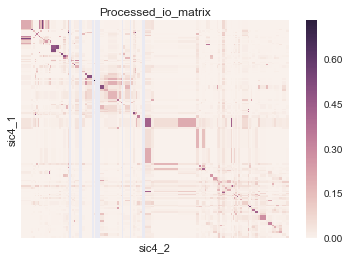

In [83]:
#Now we have the best matches. Process all this to create the io similarity matrix with SIC codes in index + col

#Create melted matrix
sic_4_mat = pd.DataFrame(index=shared_sics,columns=shared_sics)
sic_4_mat.reset_index(drop=False,inplace=True)
sic_4_melt = pd.melt(sic_4_mat,id_vars='index')
sic_4_melt.columns = ['sic4_1','sic4_2','val']

#Create lookup between sic-4 and divisions
sic_div_lookup = pd.DataFrame(sic4_io_best_matches,columns=['sic4','div_match'])

#Merges with the lookup to get the div keys:
sic_4_combs_lookup_1 = pd.merge(sic_4_melt,sic_div_lookup,
                                left_on='sic4_1',right_on='sic4',how='outer')
sic_4_combs_lookup_2 = pd.merge(sic_4_combs_lookup_1,sic_div_lookup,
                              left_on='sic4_2',right_on='sic4',how='outer')

#Create processed list dataframe
div_scores = pd.DataFrame(processed_list_2,columns=['div_1','div_2','value'])

#Merge again
sic_4_io_matrix = pd.merge(sic_4_combs_lookup_2,div_scores,
                          left_on=['div_match_x','div_match_y'],
                          right_on=['div_1','div_2'],
                          how='outer')

#Pivot
io_sim_mat = pd.pivot_table(sic_4_io_matrix,index='sic4_1',columns='sic4_2',values='value')

sns.heatmap(io_sim_mat,xticklabels=False,yticklabels=False)
plt.title("Processed_io_matrix")

In [ ]:
#Done!!

In [84]:
#Normalise all the matrices
sim_mats = [idbr_sim_mat,aps_sim_mat,io_sim_mat]
sim_mats_norm = [(x-np.mean(x))/np.std(x) for x in sim_mats]

#How do they correlate with each other?
all_coeffs = pd.concat([pd.melt(sim_mats_norm[0],value_name='cor_idbr'),
                        pd.melt(sim_mats_norm[1],value_name='cor_aps'),
                        pd.melt(sim_mats_norm[2],value_name='cor_io')],axis=1)[['cor_idbr','cor_aps','cor_io']]

all_coeffs.describe()

,cor_idbr,cor_aps,cor_io
count,2.948490e+05,2.948490e+05,2.650380e+05
mean,3.699124e-18,6.000534e-18,-2.345795e-16
std,1.000002e+00,1.000002e+00,1.000002e+00
min,-3.755313e+00,-1.366150e+00,-1.115837e+00
25%,-5.102882e-01,-3.153993e-01,-3.814773e-01
50%,-1.439374e-01,-2.004277e-01,-2.822506e-01
75%,3.858043e-01,-7.312236e-02,-7.205674e-02
max,1.880715e+01,2.317412e+01,2.239786e+01


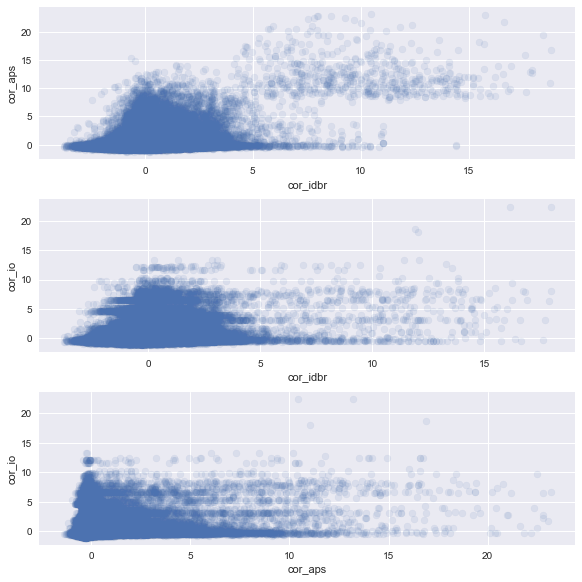

,cor_idbr,cor_aps,cor_io
cor_idbr,1.000000,0.370879,0.200204
cor_aps,0.370879,1.000000,0.271129
cor_io,0.200204,0.271129,1.000000


In [85]:
#Plot their scatters
f,ax = plt.subplots(figsize=(8,8))

plt.subplot(3,1,1)
plt.scatter(all_coeffs['cor_idbr'],all_coeffs['cor_aps'],alpha=0.1)
plt.xlabel('cor_idbr')
plt.ylabel('cor_aps')

plt.subplot(3,1,2)
plt.scatter(all_coeffs['cor_idbr'],all_coeffs['cor_io'],alpha=0.1)
plt.xlabel('cor_idbr')
plt.ylabel('cor_io')

plt.subplot(3,1,3)
plt.scatter(all_coeffs['cor_aps'],all_coeffs['cor_io'],alpha=0.1)
plt.xlabel('cor_aps')
plt.ylabel('cor_io')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

all_coeffs.corr()

In [86]:
#Estimate the mean ignoring nans (there are some in io)
sim_mat_mean = np.nanmean(np.array([np.array(i) for i in sim_mats_norm]),axis=0)

sim_mat_mean_idbr_aps = np.nanmean(np.array([np.array(i) for i in sim_mats_norm[:1]]),axis=0)

sim_mat_mean_idbr_io = np.nanmean(np.array([np.array(i) for i in [sim_mats_norm[x] for x in [0,2]]]),axis=0)

sim_mat_mean_aps_io = np.nanmean(np.array([np.array(i) for i in sim_mats_norm[1:]]),axis=0)


In [87]:
combs_3 = list(itertools.combinations([0,1,2,3],3))
matrix_names = ['idbr','bres','aps','io']
name_combs = ["_".join([matrix_names[x[0]],matrix_names[x[1]],matrix_names[x[2]]]) for x in combs_3]
name_combs

['idbr_bres_aps', 'idbr_bres_io', 'idbr_aps_io', 'bres_aps_io']

In [ ]:
##########
#1. Extract shared SICs in 4-digit matrices
##########

#All matrices need to have the same dimensions for averaging etc.
#This requires finding their intersection where we have 3-digit ones.

#Change indices and columns in SIC and APS matrices
idbr_cor = pd.read_csv(proc_data_path+'/idbr_cor.csv',index_col=0)
bres_cor = pd.read_csv(proc_data_path+'/bres_cor.csv',index_col=0)
aps_cor = pd.read_csv(proc_data_path+'/aps_cor.csv',index_col=0)
io_cor = pd.read_csv(proc_data_path+'/io_cor.csv',index_col=0)


#Set indices (NB this is simplty subsetting each column name to keep the 4-digit)
idbr_cor.index = [x[:4] for x in idbr_cor.index]
idbr_cor.columns = [x[:4] for x in idbr_cor.columns]

aps_cor.index = [x.split("_")[1] for x in aps_cor.index]
aps_cor.columns = [x.split("_")[1] for x in aps_cor.columns]

###NEED TO CHANGE THIS
bres_cor.index = [x[:4] for x in bres_cor.columns]
bres_cor.index = [x[:4] for x in bres_cor.index]

#Consolidated them based on the shared SIC codes
shared_sics = sorted(list(set(idbr_cor.index) & set(bres_cor.index) &
                     set(aps_cor.index)))

#Subset all matrices (repetitive)
# idbr_cor = idbr_cor[shared_sics]
# idbr_cor = idbr_cor.iloc[[x in shared_sics for x in idbr_cor.index],:]

# aps_cor = aps_cor[shared_sics]
# aps_cor = aps_cor.iloc[[x in shared_sics for x in aps_cor.index],:]

# bres_cor = bres_cor[shared_sics]

four_digit_matrices = [idbr_cor,bres_cor,aps_cor]
consolidated_4_digit_matrices = [consolidate_matrix(
                                                    x,shared_sics) for x in four_digit_matrices]

In [ ]:
import pickle
pickle.dump(sim_combinations,proc_data_path+"processed")

In [ ]:

#Set indices (NB this is simplty subsetting each column name to keep the 4-digit)
idbr_cor.index = [x[:4] for x in idbr_cor.index]
idbr_cor.columns = [x[:4] for x in idbr_cor.columns]

aps_cor.index = [x.split("_")[1] for x in aps_cor.index]
aps_cor.columns = [x.split("_")[1] for x in aps_cor.columns]

###NEED TO CHANGE THIS
bres_cor.index = [x[:4] for x in bres_cor.columns]
bres_cor.index = [x[:4] for x in bres_cor.index]

In [90]:

def consolidate_matrix(mat,subs):
     '''
     This function takes a aquare matrix where index=columns and
     subsets by a vector which is a subset of index.
     '''
        
     subset_1 = mat[subs]
     subset_2 = subset_1.iloc[[x in subs for x in subset_1.index],:]
     return(subset_2)


In [ ]:
idbr_cor.index = [x[:4] for x in idbr_cor.index]
idbr_cor.columns = [x[:4] for x in idbr_cor.columns]

aps_cor.index = aps_cor.columns

bres_cor.index = [x[:4] for x in bres_cor.columns]
bres_cor.columns = bres_cor.index

shared_sics = sorted(list(set(idbr_cor.index) & set(bres_cor.index) &
                     set(aps_cor.index)))

four_digit_matrices = [idbr_cor,bres_cor,aps_cor]
consolidated_4_digit_matrices = [consolidate_matrix(x,shared_sics) for x in four_digit_matrices]


##########
#2. Process the io table
###########

#The categories in the IO table are messy. This has to be cleaned thoroughly

sics_for_io = pd.DataFrame({'sics':shared_sics})

#Read the edited version of code names (tidied up manually)
codes_cleaned = pd.read_csv(int_data_path+'/divisions.csv')

#Melt to facilitate merging
io_cor.fillna(value=0,inplace=True)
io_cor.index = codes_cleaned.ix[:,1]
io_cor.index.rename('code',inplace=True)

io_cor.reset_index(drop=False,inplace=True)
melted_io = pd.melt(io_cor, id_vars ='code')

#Transform into a list
process_list = [[x,y,z] for x,y,z in zip(melted_io['code'],
                                         melted_io['variable'],
                                         melted_io['value'])]


#This loop recursively splits looks for the best sic-4 match for
#each division based on the inconsistently code information in the
#source table.

processed_list =[]

for i in range(0,len(process_list)):
    #Input the code
    code_input = process_list[i]
    code_var = code_input[0]
    #print(code_var)
    
    #Are there any &s?
    if bool(re.search("&",code_var))==True:
        offspawn = code_var.split("&")
        
        for i in offspawn:
            
            #Are there any -s?
            if bool(re.search("-",i))==True:
                
                #Split by them
                offspawn_2 = i.split("-")
                
                #Recreate numbers in the series by creating a template based on the first number, which we fill
                first_num_template = offspawn_2[0][:-1]
                
                #Filling template
                extreme_nums = [first_num_template+x if n>0 else x for n,x in enumerate(offspawn_2)]
                
                #We need to fill the space between both
                int_range = [int(x.strip()[-1]) for x in extreme_nums]
                
                #Get numbers to interpolate with
                interpol = list(range(int_range[0]+1,int_range[1]))
                
                middle_nums = [first_num_template+str(x) for x in interpol]
                
                all_nums = extreme_nums + middle_nums
                for i in all_nums:
                    processed_list.append([process_single_num(i),code_input[1],code_input[2]])
            else:
                processed_list.append([process_single_num(i),code_input[1],code_input[2]])
                    
    elif bool(re.search("-",code_var))==True:
        #Split by them
        offspawn_2 = code_var.split("-")
            
        #Recreate numbers in the series by creating a template based on the first number, which we fill
        first_num_template = offspawn_2[0][:-1]
                
        #Filling template
        extreme_nums = [first_num_template+x if n>0 else x for n,x in enumerate(offspawn_2)]
                
        #We need to fill the space between both
        int_range = [int(x.strip()[-1]) for x in extreme_nums]
                
        #Get numbers to interpolate with
        interpol = list(range(int_range[0]+1,int_range[1]))
                
        middle_nums = [first_num_template+str(x) for x in interpol]
                
        all_nums = extreme_nums + middle_nums
        for i in all_nums:
            processed_list.append([process_single_num(i),code_input[1],code_input[2]])
    else:
        processed_list.append([process_single_num(code_var),code_input[1],code_input[2]])

#Repeat the same process for the 'columns' in the melted df.
processed_list_2 = []

for i in range(0,len(processed_list)):
    #Input the code
    code_input = processed_list[i]
    code_var = code_input[1]
    #print(code_var)
    
    #Are there any &s?
    if bool(re.search("&",code_var))==True:
        offspawn = code_var.split("&")
        
        for i in offspawn:
            
            #Are there any -s?
            if bool(re.search("-",i))==True:
                
                #Split by them
                offspawn_2 = i.split("-")
                
                #Recreate numbers in the series by creating a template based on the first number, which we fill
                first_num_template = offspawn_2[0][:-1]
                
                #Filling template
                extreme_nums = [first_num_template+x if n>0 else x for n,x in enumerate(offspawn_2)]
                
                #We need to fill the space between both
                int_range = [int(x.strip()[-1]) for x in extreme_nums]
                
                #Get numbers to interpolate with
                interpol = list(range(int_range[0]+1,int_range[1]))
                
                middle_nums = [first_num_template+str(x) for x in interpol]
                
                all_nums = extreme_nums + middle_nums
                for i in all_nums:
                    processed_list_2.append([code_input[0],process_single_num(i),code_input[2]])
            else:
                processed_list_2.append([code_input[0],process_single_num(i),code_input[2]])
                    
    elif bool(re.search("-",code_var))==True:
        #Split by them
        offspawn_2 = code_var.split("-")
            
        #Recreate numbers in the series by creating a template based on the first number, which we fill
        first_num_template = offspawn_2[0][:-1]
                
        #Filling template
        extreme_nums = [first_num_template+x if n>0 else x for n,x in enumerate(offspawn_2)]
                
        #We need to fill the space between both
        int_range = [int(x.strip()[-1]) for x in extreme_nums]
                
        #Get numbers to interpolate with
        interpol = list(range(int_range[0]+1,int_range[1]))
                
        middle_nums = [first_num_template+str(x) for x in interpol]
                
        all_nums = extreme_nums + middle_nums
        for i in all_nums:
            processed_list_2.append([code_input[0],process_single_num(i),code_input[2]])
    else:
        processed_list_2.append([code_input[0],process_single_num(code_var),code_input[2]])

#Look for the best match for shared codes in the new, cleaned io codes

#These are the unique codes in the io list
cleaned_io = list(set([x[0] for x in processed_list_2]))

#Use another loop to go through each shared code and find the best match.

sic4_io_best_matches = []

for i in shared_sics:
    #Container
    comps = []
    comps.append(i)
    
    #Logic of the loop: look for matches at different levels of aggregation.
    #Needs to take into account that we lose the leading 0 when turning strings into numbers.
    if i in cleaned_io:
        comps.append(i)
        
    else:
        i_3 = str(int(int(i)/10))
        if len(i_3)<3:
            i_3 = '0'+i_3
            
        if i_3 in cleaned_io:
            comps.append(i_3)
        else:
            i_2 = str(int(int(i_3)/10))
            if len(i_2)<2:
                i_2 = '0'+i_2
            if i_2 in cleaned_io:
                comps.append(i_2)
                
    sic4_io_best_matches.append(comps)

#Now we have the best matches. Process all this to create the io similarity matrix with SIC codes in index + col

#Create melted matrix
io_sic4_cor = pd.DataFrame(index=shared_sics,columns=shared_sics)
io_sic4_cor.reset_index(drop=False,inplace=True)
io_sic4_melt = pd.melt(io_sic4_cor,id_vars='index')
io_sic4_melt.columns = ['sic4_1','sic4_2','val']

#Create lookup between sic-4 and divisions
sic_div_lookup = pd.DataFrame(sic4_io_best_matches,columns=['sic4','div_match'])

#Merges with the lookup to get the div keys:
sic_4_combs_lookup_1 = pd.merge(io_sic4_melt,sic_div_lookup,
                                left_on='sic4_1',right_on='sic4',how='outer')
sic_4_combs_lookup_2 = pd.merge(sic_4_combs_lookup_1,sic_div_lookup,
                              left_on='sic4_2',right_on='sic4',how='outer')

#Create processed list dataframe
div_scores = pd.DataFrame(processed_list_2,columns=['div_1','div_2','value'])

#Merge again
io_sic4_sim = pd.merge(sic_4_combs_lookup_2,div_scores,
                          left_on=['div_match_x','div_match_y'],
                          right_on=['div_1','div_2'],
                          how='outer')

#Pivot
io_sim = pd.pivot_table(io_sic4_sim,index='sic4_1',columns='sic4_2',values='value')

io_sim.to_csv(proc_data_path+'/io_sim.csv',index=False)

sns.heatmap(io_sim,xticklabels=False,yticklabels=False)
plt.title("Processed_io_matrix")
plt.savefig(fig_path+'/io_sim.pdf')

In [ ]:
#Estimate the mean ignoring nans (there are some in io)

matrix_names = ['idbr','bres','aps','io']


mat_names =[]
mat_averages=[]

for num in [3,2]:
    combis = list(itertools.combinations([0,1,2,3],num))
    name_combs = ["_".join([matrix_names[i] for i in x]) for x in combis]
    average_combs = [np.nanmean(np.array([np.array(sim_mats_norm[i]) for i in x]),axis=0) for x in combis]
    
    mat_names = mat_names + name_combs
    mat_averages = mat_averages + average_combs

    

sim_combinations = {x:y for x,y in zip(mat_names+matrix_names,
                                       mat_averages+sim_mats_norm)}




#sim_mat_mean_idbr_aps = np.nanmean(np.array([np.array(i) for i in sim_mats_norm[:1]]),axis=0)

#sim_mat_mean_idbr_io = np.nanmean(np.array([np.array(i) for i in [sim_mats_norm[x] for x in [0,2]]]),axis=0)

#sim_mat_mean_aps_io = np.nanmean(np.array([np.array(i) for i in sim_mats_norm[1:]]),axis=0)

In [ ]:
sim_combinations.keys()

In [ ]:
sim_mats = consolidated_4_digit_matrices+[io_sim]
sim_mats_norm = [(x-np.mean(x))/np.std(x) for x in sim_mats]

#Calculate their correlations
all_coeffs = pd.concat([pd.melt(sim_mats_norm[0],value_name='cor_idbr'),
                       pd.melt(sim_mats_norm[1],value_name='cor_bres'),
                       pd.melt(sim_mats_norm[2],value_name='cor_aps'),
                       pd.melt(sim_mats_norm[3],value_name='cor_io')],axis=1
                       )[['cor_idbr','cor_bres','cor_aps','cor_io']]

all_matrices_corr = all_coeffs.corr()
sns.heatmap(all_matrices_corr)
plt.savefig(fig_path+'/sim_correlations.pdf')

#Create dict with averaged matrices.
matrix_combs = {}
matrix_names = ['idbr','bres','aps','io']

#Now we want to create combinations of matrices
#3-way combs
combs_3 = list(itertools.combinations([0,1,2,3],3))

#Combine names
names_combs_3 = ["_".join([matrix_names[x[0]],matrix_names[x[1]],matrix_names[x[2]]]) for x in combs_3]

#Averages
averages_3 = [np.nanmean((sim_mats_norm[x[0]],
                         sim_mats_norm[x[1]],
                         sim_mats_norm[x[2]])) for x in combs_3]

#2 way combs
combs_2 = list(itertools.combinations([0,1,2,3],2))

#Combine names
names_combs_2 = ["_".join([matrix_names[x[0]],matrix_names[x[1]]]) for x in combs_2]

#Averages
averages_2 = [np.nanmean((sim_mats_norm[x[0]],
                         sim_mats_norm[x[1]])) for x in combs_2]

#Put together in dictionary

with open(proc_data_path+'/matrices.p','wb') as out:
     pickle.dump(sim_combinations,out)

## 3. Clustering

### Tasks

* Write functions that fit Kmeans and Agglomerative clusters to different dfs using K (number of clusters) as parameters
* This generates lists of clusters
* Write functions that evaluate the performance on clusters based on similarities inside and between in all the similarity matrices that we have created.
* Generate a subset of clusters, and write functions that evaluate their robustness.
* That's it.

In [92]:
#Imports
from sklearn.cluster import KMeans, AgglomerativeClustering

In [93]:
#Create idbr and aps dfs for processing

#IDBR
#Create df with rows = SICs and cols = LADs
idbr_clust_proc = sic_lqs_active.T.reset_index(drop=False)

#Create the 4-digit SIC code for masking
idbr_clust_proc.sic_4=[x.split(" :")[0] for x in idbr_clust_proc['index']]

#Mask to obtain the selected df
idbr_clust_df = idbr_clust_proc.ix[[x in shared_sics for x in idbr_clust_proc.sic_4],1:]

#APS
#Same process
aps_clust_proc = aps_lqs.T.reset_index(drop=False)
aps_clust_proc.sic_4 = [x.split("_")[1] for x in aps_clust_proc['industry']]
aps_clust_df = aps_clust_proc.ix[[x in shared_sics for x in aps_clust_proc.sic_4],1:]


#Create sic-descr lookup
sic_descr_lookup = pd.DataFrame([x.split(" :")[0] for x in idbr_sic_lad.columns[2:]],
                                [x.split(":")[1].strip() for x in idbr_sic_lad.columns[2:]]).reset_index(drop=False)
sic_descr_lookup.columns=['descr','sic_4']

sic_selected_lookup = sic_descr_lookup.ix[[x in shared_sics for x in sic_descr_lookup.sic_4],:].reset_index(drop=True)

In [94]:
def extract_kmeans(df,k,n_init=20):
    '''
    input: a df with n samples (SIC codes) vs m features (LQs)
    Output: a df with 3 columns: 4 digit code, code description & cluster allocation based on the kmeans algorithm
    
    '''
    #Initialise and fit the model
    kmeans = KMeans(n_clusters=k,n_init=n_init)
    kmeans.fit(np.array(df))
    
    #Generate outputs
    output = pd.DataFrame({'sic_4':shared_sics,
                           'descr': sic_selected_lookup.descr,
                           'clust':list(kmeans.labels_)})
    return(output)

In [95]:
def extract_agglom(df,k):
    '''
    input: a df with distances, and the number of clusters to extract
    Output: a df with 3 columns: 4 digit code, code description & cluster allocation based on ward variance 
        #minimisation algorithm
    '''
    #Fill NAs (only an issue with the input-output similarity matrix)
    if type(df)==np.ndarray:
        df = pd.DataFrame(df)
    df.fillna(value=0,inplace=True)
    
    #Initialise and fit model
    agg = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean',linkage='ward')
    agg.fit(np.array(df))
    
    #Produce output
    output = pd.DataFrame({'sic_4':shared_sics,
                           'descr': sic_selected_lookup.descr,
                           'clust':list(agg.labels_)})
    return(output)


In [96]:
#Now we need to specify the validation scores and the crossover scores.

In [97]:
def get_validation_score(clustering_output):
    '''
    input: a clustering output (df with SICs labelled with clusters obtained from a kmeans or extract agglom function)
    returns: a df where, for the cluster, we have:
        #Cluster validation scores (mean similarity inside the cluster vs mean similarities outside)
        #Industry validation scores (mean similarity of an industry inside the cluster vs. other industries)
        
    '''
    #print("running")
    #Input clustering output
    in_df = clustering_output
    
    #Group them by cluster categoru
    grouped_sics = in_df.groupby('clust')['sic_4'].apply(lambda x: list(x))
    
    #Apply the function to get validation scores to all similarity matrices and clusters configurations (C)
   
    #This will return 3 lists with two elements each.
        #0 is the cluster validation score for that matr
        #1 is the industry validation score for that matr

    all_scores = [extract_scores(grouped_sics,x) for x in agglom_k_combos]
        
    #Extract cluster scores and industry scores, 
    cluster_scores = pd.concat([pd.DataFrame(x[0]).mean(axis=0) for x in all_scores],axis=1)
    cluster_scores.columns=['c_'+x for x in ['idbr','occ','io']]

    industry_scores = pd.concat([pd.DataFrame(x[1]).mean(axis=0) for x in all_scores],axis=1)
    industry_scores.columns=['i_'+x for x in ['idbr','occ','io']]

    cluster_scores['c_mean'] = cluster_scores.mean(axis=1)
    industry_scores['i_mean'] = industry_scores.mean(axis=1)

    final_scores = pd.concat([cluster_scores,industry_scores],axis=1)
    final_scores['c_i_mean'] = final_scores[['c_mean','i_mean']].mean(axis=1)
    
    return(final_scores)

In [98]:
def extract_scores(sics,sim):
    '''
    input: sics - a series grouped by clusters and a similarity matrix to extract validation scores with
    output: Mean cluster validation scores and mean industry validation scores
    
    '''
    
    #Create container cluster score list
    cluster_score = []
    industry_score = []
    
    
    #For each index (cluster) in the grouped object
    for i in sics.index:
        #Extract the object (cluster configuration)
        sics_in_cluster = sics[i]
        
        #It doesn't make any sense to consider clusters with a single SIC code. They are not analysed here.
        if (len(sics_in_cluster)>1):
        
            #Subset the matrix to get the relevant cells (inside the cluster)
            in_cluster_mat = np.array(
                sim.ix[[x in sics_in_cluster for x in sim.index],[x in sics_in_cluster for x in sim.columns]])

            #Fill the diagonal with nans (it doesn't make sense to consider an industry's similarity to itself)
            np.fill_diagonal(in_cluster_mat,np.nan)

            #Calculate mean similarity (here we are focusing on only one of the triangles of the similarity matrix)
            wcr = np.nanmean(in_cluster_mat[np.tril_indices_from(in_cluster_mat)])
            
            #Calculate intra-cluster industry similarity.
            #We get this for each sic by summing over rows in the int matrix.
            
            wcr_ind_mat = list(pd.DataFrame(in_cluster_mat).mean(axis=1))
            

            #Create empty object to insert similarities with other clusters
            bcr_distr = []
            
            #And same thing for the industries
            bcr_ind_distr=[]

            #Loop over each of the other clusters
            for j in sics.index:
                #If we are considering a different cluster
                if i!=j & len(sics[j])>1:
                    
                    #Extract codes
                    sics_out_cluster = sics[j]
                    
                    #Create matrix where rows = industries in cluster i, and columns = industries in cluster j
                    out_cluster_mat = np.array(
                        sim.ix[[x in sics_in_cluster for x in sim.index],[x in sics_out_cluster for x in sim.columns]])   

                    #Calculate mean distances and append to bcr
                    bcr = np.mean(out_cluster_mat)
                    
                    #Put it in bcr dist
                    bcr_distr.append(bcr)
                    
                    #Then calculate the mean similarities for each sic in the initial cluster (by summing over cols)
                    bcr_ind_sim = out_cluster_mat.sum(axis=1)
                    bcr_ind_distr.append(bcr_ind_sim)
                    
            
            #Create empty dict for scores
            scs = {'95pct':np.nan,
                  'mean':np.nan}
            
            #How many times is the within cluster similarity higher than mean cluster similarity and 
                #95 pct cluster similarity?
            scs['95pct']=1 if wcr > pd.Series(bcr_distr).quantile(0.95) else 0
            scs['mean']=1 if wcr > np.nanmean(bcr_distr) else 0

            cluster_score.append(scs)
            
            
            #Here we want to compare each element in wcr_ind_mat (mean similarities between each
                #industry in a cluster and the others) vs its mean similarity with elements in other clusters,
                #and the 95pct of that similarity
            bcr_ind_df = pd.DataFrame(bcr_ind_distr)
            mean_bcr_ind = list(bcr_ind_df.mean(axis=1))
            
            pc95_bcr_ind = list(bcr_ind_df.apply(lambda x: x.quantile(0.95),axis=1))
            
            #scs_inds = [[x,y,z] for x,y,z in zip(wcr_ind_mat,mean_bcr_ind,pc95_bcr_ind)]
            
            scs_inds = [{'mean':1 if x>m else 0,
                        '95pct':1 if x> pct else 0} for x,m,pct in zip(wcr_ind_mat,mean_bcr_ind,pc95_bcr_ind)]
            
            
            industry_score.append(scs_inds)
    
    #Flatten the list
    industry_score_flat = [x for el in industry_score for x in el]
    return([cluster_score,industry_score_flat])      

In [99]:
#Dealing with a bug in pandas 
import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

In [100]:
#Generate outputs

#All mean matrices
mean_mats = [sim_mat_mean,sim_mat_mean_idbr_aps,sim_mat_mean_idbr_io,sim_mat_mean_aps_io]

agglom_k_combos = sim_mats_norm + mean_mats
kmeans_k_combos = [idbr_clust_df,aps_clust_df]

#Extraction
agglom_scores = [get_validation_score(extract_agglom(x[0],x[1])) for x in list(
        itertools.product(agglom_k_combos,list(range(30,65,2))))]
kmeans_scores = [get_validation_score(extract_kmeans(x[0],x[1])) for x in list(
        itertools.product(kmeans_k_combos,list(range(30,65,2))))]

ValueError: arrays must all be same length

In [32]:
#Extract scores from the containers and put them in a dataframe.

validation_scores_df = pd.DataFrame(x.ix['95pct',:] for x in agglom_scores+kmeans_scores).reset_index(drop=True)

#Assign names
agg_mat_names = ['idbr_sim','aps_sim','io_sim','mat_mean','idbr_aps_mean','idbr_io_mean','aps_io_mean']
kmeans_mat_names = ['idbr_clust_df','aps_clust_df']

validation_scores_df['v_names'] = [x[0] + "_" + str(x[1]) for x in list(
        itertools.product(agg_mat_names,list(range(30,65,2))))+
                                    list(itertools.product(kmeans_mat_names,list(range(30,65,2))))]

#Additional info about the findings
validation_scores_df['algo'] = ['k_means' if 'df' in x else 'ward' for x in validation_scores_df['v_names']]
validation_scores_df['k'] = [x.split("_")[-1] for x in validation_scores_df['v_names']]
validation_scores_df['type'] = ["_".join(x.split("_")[:-1]) for x in validation_scores_df['v_names']]

#Sort and get the top 10
validation_scores_df.sort(columns='c_i_mean',ascending=False)[1:15]

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:19: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,c_idbr,c_occ,c_io,c_mean,i_idbr,i_occ,i_io,i_mean,c_i_mean,v_names,algo,k,type
71,0.906250,1.000000,0.687500,0.864583,0.281768,0.572744,0.707182,0.520565,0.692574,mat_mean_64,ward,64,mat_mean
69,0.883333,1.000000,0.733333,0.872222,0.276243,0.548803,0.701657,0.508901,0.690562,mat_mean_60,ward,60,mat_mean
68,0.896552,1.000000,0.724138,0.873563,0.261510,0.558011,0.688766,0.502762,0.688163,mat_mean_58,ward,58,mat_mean
70,0.903226,1.000000,0.677419,0.860215,0.281768,0.558011,0.694291,0.511357,0.685786,mat_mean_62,ward,62,mat_mean
65,0.903846,0.980769,0.711538,0.865385,0.272560,0.545120,0.679558,0.499079,0.682232,mat_mean_52,ward,52,mat_mean
66,0.907407,0.962963,0.722222,0.864198,0.285451,0.534070,0.675875,0.498465,0.681331,mat_mean_54,ward,54,mat_mean
148,0.526316,0.947368,0.578947,0.684211,0.484848,0.818182,0.727273,0.676768,0.680489,aps_clust_df_38,k_means,38,aps_clust_df
59,0.875000,0.975000,0.850000,0.900000,0.236140,0.501027,0.611910,0.449692,0.674846,mat_mean_40,ward,40,mat_mean
117,0.791667,1.000000,0.812500,0.868056,0.207392,0.523614,0.681725,0.470910,0.669483,aps_io_mean_48,ward,48,aps_io_mean
58,0.868421,0.973684,0.842105,0.894737,0.237006,0.474012,0.617464,0.442827,0.668782,mat_mean_38,ward,38,mat_mean


In [8]:
proc_data_path = os.path.join(os.path.dirname(os.getcwd()),'data/processed')
proc_data_path

'/Users/jmateosgarcia/Desktop/projects_2016/arloesiadur_new/arloesiadur_complexity/data/processed'

In [28]:
import warnings
import pickle

proc_data_path = os.path.join(os.path.dirname(os.getcwd()),'data/processed')
int_data_path = os.path.join(os.path.dirname(os.getcwd()),'data/interim')

##########
#Functions
##########

#THERE IS A BUG SOMEWHERE IN THIS FUNCTIION. WHAT IS THE EXPECTED OUTPUT?

def process_df(data_frame):
    '''
    This function takes an lq df and returns one suitable for k-means analysis 
    in industrial segmentation, which involves transposing the data and subseting
    to obtain shared sic codes 
    '''
    x_proc = data_frame.T.reset_index(drop=False)

    #Create sic_4 for masking (NB need to branch out for different
        #conventions in the sic labels)
    if ':' in data_frame.columns[0]:
        x_proc.sic_4 = [x.split(" :")[0] for x in x_proc['index']]
    else:
        x_proc.sic_4 = [x.split("_")[1] for x in x_proc['index']]

    #Mask to obtain selected df
    x_out = x_proc.ix[[x in shared_sics for x in x_proc.sic_4],1:]
    return(x_out)



def extract_kmeans(df,k,n_init=20):
    '''
    input: a df with n samples (SIC codes) vs m features (LQs)
    Output: a df with 3 columns: 4 digit code, code description & cluster allocation based on the kmeans algorithm
    
    '''
    #Initialise and fit the model
    kmeans = KMeans(n_clusters=k,n_init=n_init)
    kmeans.fit(np.array(df))
    
    #Generate outputs
    output = pd.DataFrame({'sic_4':shared_sics,
                           'descr': sic_selected_lookup.descr,
                           'clust':list(kmeans.labels_)})
    return(output)

def extract_agglom(df,k):
    '''
    input: a df with distances, and the number of clusters to extract
    Output: a df with 3 columns: 4 digit code, code description & cluster allocation based on ward variance 
        #minimisation algorithm
    '''
    #Fill NAs (only an issue with the input-output similarity matrix)
    if type(df)==np.ndarray:
        df = pd.DataFrame(df)
    df.fillna(value=0,inplace=True)
    
    #Initialise and fit model
    agg = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean',linkage='ward')
    agg.fit(np.array(df))
    
    #Produce output
    output = pd.DataFrame({'sic_4':shared_sics,
                           'descr': sic_selected_lookup.descr,
                           'clust':list(agg.labels_)})
    return(output)

def get_validation_score(clustering_output):
    '''
    input: a clustering output (df with SICs labelled with clusters obtained from a kmeans or extract agglom function)
    returns: a df where, for the cluster, we have:
        #Cluster validation scores (mean similarity inside the cluster vs mean similarities outside)
        #Industry validation scores (mean similarity of an industry inside the cluster vs. other industries)
        
    '''
    #print("running")
    #Input clustering output
    in_df = clustering_output
    
    #Group them by cluster categoru
    grouped_sics = in_df.groupby('clust')['sic_4'].apply(lambda x: list(x))
    
    #Apply the function to get validation scores to all similarity matrices and clusters configurations (C)
   
    #This will return 3 lists with two elements each.
        #0 is the cluster validation score for that matr
        #1 is the industry validation score for that matr

    all_scores = [extract_scores(grouped_sics,x) for x in sim_mats_norm]
        
    #Extract cluster scores and industry scores, 
    cluster_scores = pd.concat([pd.DataFrame(x[0]).mean(axis=0) for x in all_scores],axis=1)
    cluster_scores.columns=['c_'+x for x in ['idbr','bres','aps','io']]

    industry_scores = pd.concat([pd.DataFrame(x[1]).mean(axis=0) for x in all_scores],axis=1)
    industry_scores.columns=['i_'+x for x in ['idbr','bres','aps','io']]

    cluster_scores['c_mean'] = cluster_scores.mean(axis=1)
    industry_scores['i_mean'] = industry_scores.mean(axis=1)

    final_scores = pd.concat([cluster_scores,industry_scores],axis=1)
    final_scores['c_i_mean'] = final_scores[['c_mean','i_mean']].mean(axis=1)
    
    return(final_scores)

def extract_scores(sics,sim):
    '''
    input: sics - a series grouped by clusters and a similarity matrix to extract validation scores with
    output: Mean cluster validation scores and mean industry validation scores
    
    '''
    
    #Create container cluster score list
    cluster_score = []
    industry_score = []
    
    
    #For each index (cluster) in the grouped object
    for i in sics.index:
        #Extract the object (cluster configuration)
        sics_in_cluster = sics[i]
        
        #It doesn't make any sense to consider clusters with a single SIC code. They are not analysed here.
        if (len(sics_in_cluster)>1):
        
            #Subset the matrix to get the relevant cells (inside the cluster)
            in_cluster_mat = np.array(
                sim.ix[[x in sics_in_cluster for x in sim.index],[x in sics_in_cluster for x in sim.columns]])

            #Fill the diagonal with nans (it doesn't make sense to consider an industry's similarity to itself)
            np.fill_diagonal(in_cluster_mat,np.nan)

            #Calculate mean similarity (here we are focusing on only one of the triangles of the similarity matrix)
            wcr = np.nanmean(in_cluster_mat[np.tril_indices_from(in_cluster_mat)])
            
            #Calculate intra-cluster industry similarity.
            #We get this for each sic by summing over rows in the int matrix.
            
            wcr_ind_mat = list(pd.DataFrame(in_cluster_mat).mean(axis=1))
            

            #Create empty object to insert similarities with other clusters
            bcr_distr = []
            
            #And same thing for the industries
            bcr_ind_distr=[]

            #Loop over each of the other clusters
            for j in sics.index:
                #If we are considering a different cluster
                if i!=j & len(sics[j])>1:
                    
                    #Extract codes
                    sics_out_cluster = sics[j]
                    
                    #Create matrix where rows = industries in cluster i, and columns = industries in cluster j
                    out_cluster_mat = np.array(
                        sim.ix[[x in sics_in_cluster for x in sim.index],[x in sics_out_cluster for x in sim.columns]])   

                    #Calculate mean distances and append to bcr
                    bcr = np.mean(out_cluster_mat)
                    
                    #Put it in bcr dist
                    bcr_distr.append(bcr)
                    
                    #Then calculate the mean similarities for each sic in the initial cluster (by summing over cols)
                    bcr_ind_sim = out_cluster_mat.sum(axis=1)
                    bcr_ind_distr.append(bcr_ind_sim)
                    
            
            #Create empty dict for scores
            scs = {'95pct':np.nan,
                  'mean':np.nan}
            
            #How many times is the within cluster similarity higher than mean cluster similarity and 
                #95 pct cluster similarity?
            scs['95pct']=1 if wcr > pd.Series(bcr_distr).quantile(0.95) else 0
            scs['mean']=1 if wcr > np.nanmean(bcr_distr) else 0

            cluster_score.append(scs)
            
            
            #Here we want to compare each element in wcr_ind_mat (mean similarities between each
                #industry in a cluster and the others) vs its mean similarity with elements in other clusters,
                #and the 95pct of that similarity
            bcr_ind_df = pd.DataFrame(bcr_ind_distr)
            mean_bcr_ind = list(bcr_ind_df.mean(axis=1))
            
            pc95_bcr_ind = list(bcr_ind_df.apply(lambda x: x.quantile(0.95),axis=1))
            
            #scs_inds = [[x,y,z] for x,y,z in zip(wcr_ind_mat,mean_bcr_ind,pc95_bcr_ind)]
            
            scs_inds = [{'mean':1 if x>m else 0,
                        '95pct':1 if x> pct else 0} for x,m,pct in zip(wcr_ind_mat,mean_bcr_ind,pc95_bcr_ind)]
            
            
            industry_score.append(scs_inds)
    
    #Flatten the list
    industry_score_flat = [x for el in industry_score for x in el]
    return([cluster_score,industry_score_flat])      

#Extract overlap scores
def extract_overlap_scores(threshold):
    '''
    input: A threshold for the number of clusters to focus on
    output: returns a df with overlap scores for each of the matrices.
    '''
    
    #Sort and subset the DF to get the similarity matrices we're interested in
    top_vs = validation_scores_df.sort(
        columns='c_i_mean',ascending=False).reset_index(drop=False).ix[:threshold,['k','type']]

    #NB need tore-write this to also include aps_cluster_df (outputs of Kmeans). Those get high
    #validation scores but not for the right reasons i.e. they have lots of singleton clusters excluded
    #from the validation scoring process (when we do if len(sics_in_cluster)>1). 
    #Need to re-write the validating score function to deal with this,
    #e.g. by not doing means of scores but sums divided by total number of clusters.
    
    #This is a lookup to get the matrices.
    type_mat_lookup ={
    "mat_mean":sim_mat_mean,
    "aps_io_mean":sim_mat_mean_aps_io
    }
    
    #Create combinations of matrices and ks
    my_combs = [[m,type_mat_lookup[m],k] for m,k in zip(top_vs.type,top_vs.k) if m not in 
                ["aps_clust_df","idbr_clust_df"]]

    combinations = list(itertools.combinations(my_combs,2))

    #For each of the pairs, calculate the overlap score (based on the cluster with the greatest overlap)
    results=[]
    
    for i in combinations:
        #if i[0][0]!=i[1][0]:
        #print("running")
        
        #Extract clusters
        c1 = extract_agglom(i[0][1],int(i[0][2])).groupby('clust')['sic_4'].apply(lambda x: list(x))
        c2 = extract_agglom(i[1][1],int(i[1][2])).groupby('clust')['sic_4'].apply(lambda x: list(x))
        
        
        c_max_overlap = []
            #For each of the clusters, find the cluster with the maximum overlap, and estimate the overlap score
        for j in c1.index:
            
            #Overlaps with all other clusters
            overlaps = [len(list(set(c1[j]) & set(c2[n]))) for n in c2.index]
            
            #Index for maximum overlap
            max_overlap = overlaps.index(max(overlaps))
            
            #Overlap score
            overlap = 100*(len(list(set(c1[j]) & set(c2[max_overlap])))/math.sqrt(
                    (len(set(c1[j]))*len(set(c2[max_overlap])))))
            #Add to the scores
            c_max_overlap.append(overlap)
        
        #Append the results (with info about what the matrix os)
        results.append([i[0][0]+"_"+str(i[0][2]),
                        i[1][0]+"_"+str(i[1][2]),
                        np.mean(c_max_overlap)])
        
    #Calculate the average overlap scores for each similarity matrix-k combo...in a hacky way.
    results = pd.DataFrame(results)
    
    results.columns= ['m1','m2','val']
    results_store=[]
    
    #Subset the matrix for values equal to each of the unique matrix - k combo and get the mean
    for i in set(list(results.m1.values)+list(results.m2.values)):
        mat_ind = [m1 == i or m2==i for m1,m2 in zip(results.m1,results.m2)]
        mat_subs = results.ix[mat_ind,'val'].mean()
        results_store.append([i,mat_subs])
    #Extract
    return(pd.DataFrame(results_store,columns=['mat','mean_overlap_score']))

#Other
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

##########
#1. Load data and prepare for analysis
##########

#Load the dict with the matrices
#Load the dict with the matrices
with open(proc_data_path+'/sim_matrices.p','rb') as infile:
     sim_combinations = pickle.load(infile)

#We extract the shared_sics we use to consolidate dfs from the idbr df (it could have
     #been another one)
shared_sics = sim_combinations['idbr'].index

#Load LQ dfs for K-means clustering
sources = ['idbr','bres','aps']
lq_matrices = [pd.read_csv(proc_data_path+'/{src}_lqs.csv'.format(src=x)) for x in sources]

#Create idbr and aps dfs for processing
lq_matrices_processed = [process_df(x) for x in lq_matrices]

#Load sic-description lookup and select shared sics
sic_descr_lookup = pd.read_csv(int_data_path+'nomis_sic_names.csv')

sic_selected_lookup = sic_descr_lookup.ix[[x in shared_sics for x in sic_descr_lookup.sic_4],:].reset_index(drop=True)


In [31]:
sic_descr_lookup = pd.read_csv(int_data_path+'nomis_sic_names.csv')
sic_descr_lookup.sic_4 = [str(x) if len(str(x))==4 else "0"+str(x) for x in sic_descr_lookup.sic_4]
sic_selected_lookup = sic_descr_lookup.ix[[x in shared_sics for x in sic_descr_lookup.sic_4],:].reset_index(drop=True)

In [ ]:
agglom_k_combos = list(sim_combinations.values())
kmeans_k_combos = lq_matrices_processed

agglom_scores = [get_validation_score(extract_agglom(x[0],x[1])) for x in list(
        itertools.product(agglom_k_combos,list(range(30,80,3))))]

In [ ]:
##########
#2. Cluster analysis
##########

#Inputs
agglom_k_combos = list(sim_combinations.values())
kmeans_k_combos = lq_matrices_processed

#Perform segmentation
agglom_scores = [get_validation_score(extract_agglom(x[0],x[1])) for x in list(
        itertools.product(agglom_k_combos,list(range(30,80,3))))]
kmeans_scores = [get_validation_score(extract_kmeans(x[0],x[1])) for x in list(
        itertools.product(kmeans_k_combos,list(range(30,80,3))))]

validation_scores_df = pd.DataFrame(x.ix['95pct',:] for x in agglom_scores+kmeans_scores).reset_index(drop=True)

#Assign names
agg_mat_names = sim_combinations.keys()
kmeans_mat_names = ['idbr_lqs','bres_lqs','aps_lqs']

validation_scores_df['v_names'] = [x[0] + "_" + str(x[1]) for x in list(
        itertools.product(agg_mat_names,list(range(30,80,3))))+
                                    list(itertools.product(kmeans_mat_names,list(range(30,80,3))))]

#Additional info about the findings
validation_scores_df['algo'] = ['k_means' if 'df' in x else 'ward' for x in validation_scores_df['v_names']]
validation_scores_df['k'] = [x.split("_")[-1] for x in validation_scores_df['v_names']]
validation_scores_df['type'] = ["_".join(x.split("_")[:-1]) for x in validation_scores_df['v_names']]

#Sort and get the top 10
validation_scores_df.to_csv(proc_data_path+'/clustering_scores.csv')
#validation_scores_df.sort(columns='c_i_mean',ascending=False)[1:15]

In [34]:
extract_agglom(sim_mat_mean,k=56).sort(columns='clust').to_csv("intermediate_outputs/clusters.csv")
extract_kmeans(aps_clust_df,k=30).sort(columns='clust').to_csv("intermediate_outputs/clusters_2.csv")

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [35]:
#Extract overlap scores
def extract_overlap_scores(threshold):
    '''
    input: A threshold for the number of clusters to focus on
    output: returns a df with overlap scores for each of the matrices.
    '''
    
    #Sort and subset the DF to get the similarity matrices we're interested in
    top_vs = validation_scores_df.sort(
        columns='c_i_mean',ascending=False).reset_index(drop=False).ix[:threshold,['k','type']]

    #NB need tore-write this to also include aps_cluster_df (outputs of Kmeans). Those get high
    #validation scores but not for the right reasons i.e. they have lots of singleton clusters excluded
    #from the validation scoring process (when we do if len(sics_in_cluster)>1). 
    #Need to re-write the validating score function to deal with this,
    #e.g. by not doing means of scores but sums divided by total number of clusters.
    
    #This is a lookup to get the matrices.
    type_mat_lookup ={
    "mat_mean":sim_mat_mean,
    "aps_io_mean":sim_mat_mean_aps_io
    }
    
    #Create combinations of matrices and ks
    my_combs = [[m,type_mat_lookup[m],k] for m,k in zip(top_vs.type,top_vs.k) if m not in 
                ["aps_clust_df","idbr_clust_df"]]

    combinations = list(itertools.combinations(my_combs,2))

    #For each of the pairs, calculate the overlap score (based on the cluster with the greatest overlap)
    results=[]
    
    for i in combinations:
        #if i[0][0]!=i[1][0]:
        #print("running")
        
        #Extract clusters
        c1 = extract_agglom(i[0][1],int(i[0][2])).groupby('clust')['sic_4'].apply(lambda x: list(x))
        c2 = extract_agglom(i[1][1],int(i[1][2])).groupby('clust')['sic_4'].apply(lambda x: list(x))
        
        
        c_max_overlap = []
            #For each of the clusters, find the cluster with the maximum overlap, and estimate the overlap score
        for j in c1.index:
            
            #Overlaps with all other clusters
            overlaps = [len(list(set(c1[j]) & set(c2[n]))) for n in c2.index]
            
            #Index for maximum overlap
            max_overlap = overlaps.index(max(overlaps))
            
            #Overlap score
            overlap = 100*(len(list(set(c1[j]) & set(c2[max_overlap])))/math.sqrt(
                    (len(set(c1[j]))*len(set(c2[max_overlap])))))
            #Add to the scores
            c_max_overlap.append(overlap)
        
        #Append the results (with info about what the matrix os)
        results.append([i[0][0]+"_"+str(i[0][2]),
                        i[1][0]+"_"+str(i[1][2]),
                        np.mean(c_max_overlap)])
        
    #Calculate the average overlap scores for each similarity matrix-k combo...in a hacky way.
    results = pd.DataFrame(results)
    
    results.columns= ['m1','m2','val']
    results_store=[]
    
    #Subset the matrix for values equal to each of the unique matrix - k combo and get the mean
    for i in set(list(results.m1.values)+list(results.m2.values)):
        mat_ind = [m1 == i or m2==i for m1,m2 in zip(results.m1,results.m2)]
        mat_subs = results.ix[mat_ind,'val'].mean()
        results_store.append([i,mat_subs])
    #Extract
    return(pd.DataFrame(results_store,columns=['mat','mean_overlap_score']))
    

In [36]:
results = extract_overlap_scores(10)
results.sort(columns='mean_overlap_score',ascending=False)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,mat,mean_overlap_score
6,mat_mean_56,91.489813
0,mat_mean_58,90.326844
1,mat_mean_54,89.905446
4,mat_mean_60,89.665171
5,mat_mean_62,89.082636
2,mat_mean_52,89.047650
9,mat_mean_64,87.431118
7,mat_mean_40,81.450464
3,mat_mean_38,79.188977
8,aps_io_mean_48,72.562685


In [37]:
#Scores look quite high at th top. I'd go for mat mean 60, 56 or 58.
#Next steps: 
#Get the SIC codes through extract_agglom, consolidate in the initial idbr matrix and re-calculate LQs per LAD.

#Focus on mat_means_56
extract_agglom(sim_mat_mean,k=64).sort(columns='clust').to_csv("intermediate_outputs/clusters_64.csv")

#We relabel the data offline and load (nb flags are clusters with potential issues (funnies, similarity to
    #other clusters etc)) This should eventually be revised.
ind_clusters_labelled = pd.read_csv("intermediate_outputs/clusters_64_labelled.csv",
                                    encoding = "ISO-8859-1")

ind_clusters_labelled.head()

#And now need to convert the sic codes into strings with a leading zero if they are smaller than 1. 
#TODO refactor, I am repeating myself

ind_clusters_labelled['sic_4_string'] = [
    "0"+str(x) if len(str(x))<4 else str(x) for x in ind_clusters_labelled.sic_4]


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


## 4. Process SIC4 data into new clusters

* Merge clusters with idbr matrix, re-calculate LQs.
* Stretch (if needed) - extract 2011 data and analyse changes.
* Perform a Hidalgo-style analysis: diversity vs ubiquity, create map of the 'industry space'.



In [38]:
#Merge.

#Get the df
idbr_clusters_process = idbr_sic_lad.copy()
idbr_clusters_process.rename(columns={'local authority: district / unitary (prior to April 2015)':'lad_name',
                                     'mnemonic':'lad_code'},inplace=True)

#Melt and create sic_4 variable to merg with clusters
idbr_clusters_process2 = pd.melt(idbr_clusters_process,id_vars=['lad_name','lad_code'])
idbr_clusters_process2['sic_4_l'] = idbr_clusters_process2['variable'].apply(lambda x:
                                                                          x.split(":")[0].strip())

idbr_clusters_merged = pd.merge(idbr_clusters_process2,ind_clusters_labelled,
                               left_on='sic_4_l',right_on='sic_4_string',how='inner')

In [39]:
dis = list(set(idbr_clusters_process2.sic_4_l) - set(ind_clusters_labelled.sic_4_string))
print("{dis} have dropped out from the analysis - why?".format(dis=len(dis)))

73 have dropped out from the analysis - why?


In [40]:
missing_sic4s = idbr_clusters_process2.ix[[
        x in dis for x in idbr_clusters_process2.sic_4_l],['variable','value','sic_4_l']].groupby(
    "sic_4_l")['value'].sum()

#In most cases they simply have no activity.
missing_sic4s.sort_values(ascending=False)[1:10]

#But there are 3 missing from there. What are they? Values missing from aps? Todo: check this.

sic_4_l
4624    75.0
0144     5.0
9900     0.0
1042     0.0
1062     0.0
1073     0.0
1081     0.0
1102     0.0
1104     0.0
Name: value, dtype: float64

In [41]:
#Pivot the merged df
#This aggregates levels of activity over clusters
idbr_clusters_counts = pd.pivot_table(idbr_clusters_merged,
                        index='lad_name',columns=['label'],values='value',aggfunc=np.sum,fill_value=0)
idbr_clusters_counts.reset_index(drop=False,inplace=True)

#Create a DF with LQs

area_shares = idbr_clusters_counts.sum(axis=1)/np.sum(idbr_clusters_counts.sum(axis=1))

idbr_clusters_lqs = pd.concat([idbr_clusters_counts['lad_name'],
                              idbr_clusters_counts.ix[:,1:].apply(lambda x: (x/x.sum())/area_shares,axis=0)],
                              axis=1)

In [42]:
#Extract the top 10 areas per sector.
#Removing areas with low levels of activity.

def extract_sector_tops(sector,threshold=15,mass=0.5):
    '''
    This function takes a sector name and returns the top thres (default=10) clusters above
        #a minimum level of industry mass (default=0.5)
    
    '''
    
    #identify areas above min mass in the idbr_cluster_counts df
    #Value
    min_act = idbr_clusters_counts[sector].quantile(mass)
    min_act_mask = idbr_clusters_counts[sector]>min_act
    
    #identify high lads
    high_lads = list(idbr_clusters_counts['lad_name'][min_act_mask])
    
    #Subset the lq by these
    lq_subset = idbr_clusters_lqs.ix[[x in high_lads for x in idbr_clusters_lqs.lad_name],
                                     ['lad_name',sector]]
    
    tops = list(lq_subset.sort(columns=sector,ascending=False)[:threshold]['lad_name'][:threshold])
    
    output = {'sector':sector,
             'top_areas':[tops]}
    return(output)


def extract_area_tops(area,threshold=10,mass=0.33):
    '''
    This function takes a lad name and returns its top thres sectors (as long as they are
        #above a minimum level of local mass)
    '''
    
    #Get area min value
    idbr_indexed = idbr_clusters_counts.set_index('lad_name')
    area_act = idbr_indexed.loc[area]
    min_act = area_act.quantile(mass)
    
    #Identify sectors above the min_act threshold
    tops = list(area_act.index[[x > min_act for x in area_act]])
    
    #Subset the LQ df by these sectors/area
    
    area_df = idbr_clusters_lqs.ix[idbr_clusters_lqs.lad_name==area,
                                 [x in tops for x in idbr_clusters_lqs.columns]].T
    
    area_df.columns=['lq']
    area_df.reset_index(drop=False,inplace=True)
    
    tops = list(area_df.sort(columns='lq',ascending=False)[:threshold]['index'])
    
    output = {'area':area,
             'top_areas':[tops]}
    return(output)

In [43]:
top_per_sector = pd.concat([pd.DataFrame(extract_sector_tops(x,threshold=15)) for x in idbr_clusters_lqs.columns[1:]])
top_per_area = pd.concat([pd.DataFrame(extract_area_tops(x)) for x in idbr_clusters_lqs.lad_name])

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:23: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:52: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [44]:
top_per_area.to_csv("intermediate_outputs/area_esp.csv")

In [45]:
idbr_clusters_lqs.to_csv("intermediate_outputs/industry_clusters.csv",index=False)

## 5. Diversity analysis

**Tasks**
* Produce the specialisation matrix
* Produce the economic complexity metrix
* Product the industry space index



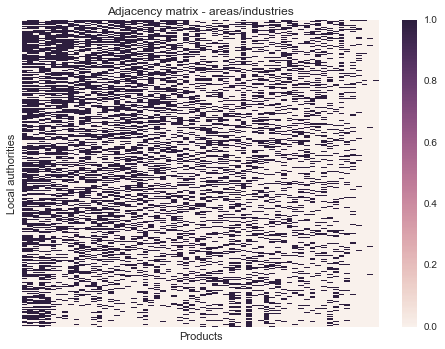

In [46]:
#Specialisation matrix:
location_industry_adjacency =  idbr_clusters_lqs.ix[:,1:].applymap(lambda x: 1 if x>1 else 0)

#Order by columns and rows
sorted_sectors = list(location_industry_adjacency.sum().sort_values(ascending=False).index)
sorted_areas = list(location_industry_adjacency.sum(axis=1).sort_values(ascending=False).index)

#Rejigged matrix:
location_industry_adjacency_ordered =location_industry_adjacency.ix[sorted_areas,sorted_sectors]

sns.heatmap(location_industry_adjacency_ordered,xticklabels=False,yticklabels=False)

plt.title("Adjacency matrix - areas/industries")
plt.xlabel("Products")
plt.ylabel("Local authorities")
plt.savefig("outputs/adj_mat_area_ind.pdf")

In [47]:
#Most 'diverse' areas
div_lads = idbr_clusters_lqs['lad_name'][sorted_areas]
print(", ".join(div_lads[1:10]))

#Least ubiquitous sectors
#It's picking up lots of natural resources
print(", ".join(sorted_sectors[:10]))

Kingston upon Hull, City of, County Durham, Bradford, Basildon, Fife, Bristol, City of, Stockport, Test Valley, Nottingham
construction, services_automotive, manufacture_machinery, services_agriculture_rural, manufacture_furniture, services_waste_recycling, services_repair_machinery, manufacture_plastic, services_cleaning_facilities, services_consumer_retail


In [48]:
#Now we need to take this to the next level

In [49]:
def eci_algorithm_simplified(adj_matrix,iterations=3):
    '''
    This algorithm replicates the work in HH. It takes a matrix and a number of
    iterations to apply the method of reflections. 
    The output is len=number of iterations. Each element contains a list with two elements:
        Element one is a vector of values for each area.
        Element 1 is a vector of values for each industry
    
    -For areas, if the value of the iteration is even (0,2,4...), the vector captures the 
    level of diversification of the area. After the first iteration, this is weighted by the diversity
    of other areas with the same industries.
    
    If the value of the iteration is odd (1,3,5), the vector captures the ubiquity of its industries.
    
    -For industries, if the value of the iteration is even (0,2,4,...) the vector captures the level of
    ubiquity of each industry. After the first iteration, this is weighted by the ubiquity of other areas with
    the same industries.
    
    If the value of the iteration is odd (1,3,5) the vector captures the diversity of the areas that specialise
    in this industry.
    
    '''
    #Initial diversity vector
    div_vect = adj_matrix.sum(axis=1)
    
    #Initial diversity vector
    ubi_vect = adj_matrix.sum()
    
    #Iterator
    
    #Create containers
    kc = [list(div_vect)]
    kp = [list(ubi_vect)]
    
    #Initialise
    i = 0
    
    while i<=iterations:
        #print(i)
        eci_cont=[]
        epi_cont=[]
        
        for country in adj_matrix.index:
            eci=(1/div_vect[country])*np.sum(adj_matrix.ix[country,:]*kp[i])
            eci_cont.append(eci)
        
        for product in adj_matrix.columns:
            epi = (1/ubi_vect[product])*np.sum(adj_matrix.ix[:,product]*kc[i])
            epi_cont.append(epi)
        i +=1
        kc.append(eci_cont)
        kp.append(epi_cont)
     
    #print(kp[0].index)
    out = [[pd.Series(x,index=idbr_clusters_lqs['lad_name']),
           pd.Series(y,index=ubi_vect.index)] for x,y in zip(kc,kp)]
    return(out)
    

In [50]:
reflections_output = eci_algorithm_simplified(location_industry_adjacency,iterations=16)

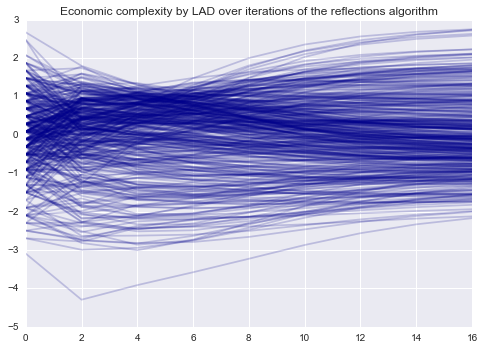

In [106]:
diversity_scores = pd.concat([pd.DataFrame(x[0],columns=[str(num)]) 
                              for num,x in enumerate(reflections_output) if num % 2==0],axis=1)
diversity_scores_norm = diversity_scores.apply(lambda x: scipy.stats.zscore(x))

for i in diversity_scores_norm.index:
    data = diversity_scores_norm.ix[i,:]
    plt.plot(data,alpha=0.2,color='darkblue')
    
plt.title("Economic complexity by LAD over iterations of the reflections algorithm")

plt.savefig("outputs/complexity_graph")


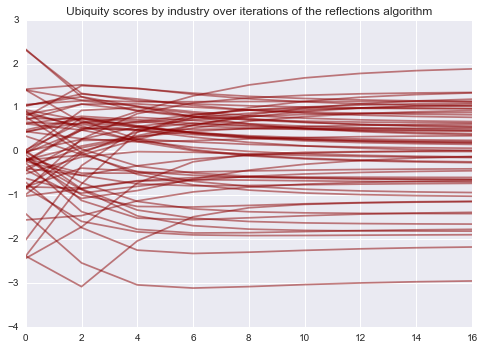

In [52]:
ubiquity_scores = pd.concat([pd.DataFrame(x[1],columns=[str(num)]) 
                              for num,x in enumerate(reflections_output) if num % 2==0],axis=1)
ubiquity_scores_norm = ubiquity_scores.apply(lambda x: scipy.stats.zscore(x))

for i in ubiquity_scores_norm.index:
    data = ubiquity_scores_norm.ix[i,:]
    plt.plot(data,alpha=0.5,color='darkred')
    
plt.title("Ubiquity scores by industry over iterations of the reflections algorithm")

In [53]:
#What are the most and least diversified areas?
div_out = reflections_output[16][0].sort_values(ascending=False)

print("10 most diversified LADs are {areas} and the 10 least diversified areas are {areas_2}".
      format(areas=", ".join(div_out[:10].index),areas_2=", ".join(div_out[-10:].index)))

print(" ")

#What industries are the most ubiquitous?
ubi_out = reflections_output[16][1].sort_values(ascending=False)

print("10 most ubiquitous industries are {inds} and the 10 least ubiquitous industries are {inds_2}".
      format(inds=", ".join(ubi_out[:10].index),inds_2=", ".join(ubi_out[-10:].index)))

10 most diversified LADs are St Albans, Lambeth, Wandsworth, Richmond upon Thames, Elmbridge, Southwark, Bromley, Barnet, Chiltern, Merton and the 10 least diversified areas are Ballymoney, Magherafelt, Strabane, Larne, Coleraine, Omagh, Torridge, Fermanagh, Limavady, Moyle
 
10 most ubiquitous industries are primary_livestock, primary_mining, primary_fishing, services_leisure, manufacture_machinery, manufacture_furniture, primary_farming, primary_forestry, services_agriculture_rural, services_urban_transport and the 10 least ubiquitous industries are services_travelling_tourism, manufacture_light_misc, services_publishing, services_business_support, services_human_resources, services_kibs, services_computing, services_finance_real_state, services_creative, services_creative_content


In [54]:
#Let's park this. Other analytical options would include:
#Anal§yse the link between diversity and economic performance like H&H have done.

## 6. Industry space analysis

* Tasks: Create similarity matrix between sectors (based on co-location, SIC codes). Write this as a function to facilitate reproduction with different matrices.
* Create a network graph of the similarity matrix by builing a maximum spanning tree and adding highly weighted edges. This will have an industry property to label industries.
* Write a function that takes an area and highlights its areas of specialisation within the product space. Need to think about how this will work.




In [55]:
#Task 1:

def get_similarity_df(specialisation_df,threshold=1):
    '''
    We produce a metric with similarities between sectors for plotting. Question: Why not do this using the
        #similarity matrices from the analysis above? Could be a robustness test.
        
    input: a df with area specialisation in a sector (rows = areas and columns=sectors). Threshold specifies
        #specialisation score above which we consider an area specialised in a sector.
    output: a similarity matrix measuring co-specialisation between sectors
    
    '''
    
    #Create the dummies matrix
    df_dummy = specialisation_df.applymap(lambda x: 0 if x<threshold else 1)
    
    #Create the container df
    container_df = pd.DataFrame(columns=df_dummy.columns,
                               index=df_dummy.columns)
    
    #sic_combos = itertools.product(df_dummy.columns)
    #sic_values = [get_probability(x,y) for x,y in sic_combos]
    
    #Loop over pairs of columns (sectors)
    for i in container_df.columns:
        for j in container_df.columns:
            
            #Sum the number of times the sectors appear together
            num=np.sum(df_dummy.ix[:,i]*df_dummy.ix[:,j])
            
            #Get the maximum of the times the sectors appear
            den = np.max([df_dummy.ix[:,i].sum(),df_dummy.ix[:,j].sum()])
            
            #Create the measure of similarity
            container_df.ix[i,j]=num/den
    #Return
    return(container_df)

In [56]:
def get_cond_prob(x,y):
    num=np.sum(df_dummy.ix[:,x]*df_dummy.ix[:,y])
            
            #Get the maximum of the times the sectors appear
    den = np.max([df_dummy.ix[:,x].sum(),df_dummy.ix[:,y].sum()])
    return(num)
    

In [57]:
#sic_combos = itertools.product(lqs_matrix_to_plot,lqs_matrix_to_plot)
#df_dummy= lqs_matrix_to_plot.applymap(lambda x: 1 if x>1 else 0)
#outs = [get_cond_prob(x[0],x[1]) for x in sic_combos]

In [58]:
#We are focusing on SICs
lqs_matrix_to_plot = sic_lqs

#Rename columns
lqs_matrix_to_plot.columns=[x.split(":")[0].strip() for x in lqs_matrix_to_plot.columns]

In [59]:
#Extract similarity df. It takes some time. The function above could probably be refactored to speed things up.
#similarity_df = get_similarity_df(idbr_clusters_lqs.ix[:,1:])
similarity_df_sic = get_similarity_df(lqs_matrix_to_plot)

In [60]:
#Remove for the matrix SIC codes with no activity
non_empty_sics = similarity_df_sic.sum().index[[x!=0 for x in similarity_df_sic.sum()]]

#Create the edge list (removing duplicates)
similarity_df_clean = similarity_df_sic.ix[non_empty_sics,non_empty_sics].reset_index(drop=False)
similarity_edgelist = pd.melt(similarity_df_clean,id_vars='index')

similarity_edgelist.columns=['e1','e2','weight']

#Drop diagonal and instances where weight=0
#This gives us the edge list
similarity_edgelist = similarity_edgelist.ix[[x!=y and w!=0 for x,y,w in zip(
            similarity_edgelist.e1,
            similarity_edgelist.e2,
            similarity_edgelist.weight)],:]

In [61]:
#Network 1: Using SIC codes, without maximum spanning tree
import networkx as nx
#Sector sic lookup
sic_sector_lookup = {x:y for x,y in zip(ind_clusters_labelled.sic_4_string,ind_clusters_labelled.label)}

#Create a network object and make undirected
sim_net = nx.from_pandas_dataframe(similarity_edgelist,source='e1',target='e2',edge_attr=['weight'])
sim_net_ud = sim_net.to_undirected()

#Need to convert the weights to floats.
for i in sim_net_ud.edges():
    sim_net_ud.edge[i[0]][i[1]]['weight']= float(sim_net_ud.edge[i[0]][i[1]]['weight'])

#Identify weight threshold for graphing
weight_top_pc = pd.Series([list(w.values())[0] for u,v,w in sim_net_ud.edges(data=True)]).quantile(0.90)

#Select edges above that weight
subgraph_edges = [(u,v,w) for u,v,w in sim_net_ud.edges(data=True) if w['weight']>=weight_top_pc]

#Create the netwotk
sim_net_subset = nx.Graph(subgraph_edges)
    
nx.write_graphml(sim_net_subset,"intermediate_outputs/networks.graphml")

In [62]:
#Network 2: SIC codes based on maximum spanning tree

sim_net_tree = nx.maximum_spanning_tree(sim_net_ud,'weight')

#Create network with strong edges and edges in the maximum spanning tree
sim_net_mst_subset = nx.Graph(subgraph_edges+list(sim_net_tree.edges()))

#Add cluster labels
for i in sim_net_mst_subset.nodes():
    try:
        sim_net_mst_subset.node[i]['industry_cluster']=sic_sector_lookup[i]
    except:
        sim_net_mst_subset.node[i]['industry_cluster']='no_label'
        
nx.write_graphml(sim_net_mst_subset,"intermediate_outputs/networks_sics.graphml")

In [63]:
#Network 3: Sector matrix based on our industry clusters
#Similarity matrix
similarity_df = get_similarity_df(idbr_clusters_lqs.ix[:,1:])

#Create the edge list
#similarity_df_clean = similarity_df.ix[non_empty_sics,non_empty_sics].reset_index(drop=False)
similarity_edgelist = pd.melt(similarity_df.reset_index(drop=False),id_vars='index')

similarity_edgelist.columns=['e1','e2','weight']

#Drop diagonal and instances where weight=0
similarity_edgelist = similarity_edgelist.ix[[x!=y and w!=0 for x,y,w in zip(
            similarity_edgelist.e1,
            similarity_edgelist.e2,
            similarity_edgelist.weight)],:]

#Create a network object
sim_net = nx.from_pandas_dataframe(similarity_edgelist,source='e1',target='e2',edge_attr=['weight'])
sim_net_ud = sim_net.to_undirected()

#Need to convert the weights to floats.
for i in sim_net_ud.edges():
    sim_net_ud.edge[i[0]][i[1]]['weight']= float(sim_net_ud.edge[i[0]][i[1]]['weight'])
    
#Identify weight threshold for graphing
weight_top_pc = pd.Series([list(w.values())[0] for u,v,w in sim_net_ud.edges(data=True)]).quantile(0.50)

#Select edges above that weight
subgraph_edges = [(u,v,w) for u,v,w in sim_net_ud.edges(data=True) if w['weight']>=weight_top_pc]

#Extract the maximum spanning tree
sim_net_mst_ind = nx.minimum_spanning_tree(sim_net_ud)    

#Create the netwotk
sim_net_ind = nx.Graph(subgraph_edges+list(sim_net_mst_ind.edges()))
#sim_net_sub = nx.Graph(subgraph_edges)    
    
nx.write_graphml(sim_net_ind,"intermediate_outputs/networks_clusters.graphml")

In [64]:
#Tidy up the above!
#Produce network graph of the 'industry space' using igraph. Write function that highlights the industries that
#A location specialises on.

In [65]:
#biz_for_james = pd.read_csv("../../temp_data_files/business_counts_2015.csv").reset_index(drop=True)

In [66]:
#biz_for_james_props = 100*biz_for_james.ix[:,2:].apply(lambda x: x/x.sum(),axis=1)
#biz_for_james_props.index = biz_for_james.ix[:,1]
#biz_for_james_props.to_csv("../../temp_data_files/business_count_2015_props.csv")

## 7. Extra analysis for the blog

In [67]:
#How many of the clusters have components in different sections.
#Plan: group by clust, create a value count table with the first two numbers of the sic_4 string. How many
#of them contain sic codes from more than 2 divisions?

def get_prop_in_top_division(sic_strings):
    '''
    Input: a vector of 4-digit SIC codes; we will extract the first two strings, and check what proportion is
    #in the top one. After, we can do averages, or count how many clusters contain sic-4s in the same divisions.
    
    '''
    
    sic_2s = pd.Series([x[0:2] for x in sic_strings])
    sic_vals = sic_2s.value_counts()/len(sic_2s)
    
    #Outputs
    #Percentage of sic_4s in the top division
    top_perc = sic_vals[0]
    
    #Number of divisions
    div_num = len(sic_vals)
    
    return(pd.DataFrame({'top_div_perc':top_perc,'number_divs':div_num},index=[0]))

In [68]:
cluster_spread_stats = ind_clusters_labelled.groupby('clust')[
    'sic_4_string'].apply(get_prop_in_top_division).reset_index(level=1,drop=True)

In [69]:
perc_several_divs = np.sum(cluster_spread_stats.number_divs>1)/len(cluster_spread_stats)
mean_prop_accounted_by_top_div = cluster_spread_stats.top_div_perc.mean()

print("The percentage of clusters with 4-digit SIC codes from more than 1 division is {x}%".
     format(x=perc_several_divs*100))
print("The average proportion of SICs accounted by the top division in a cluster is {x}%".
     format(x=np.round(mean_prop_accounted_by_top_div,5)*100))


The percentage of clusters with 4-digit SIC codes from more than 1 division is 71.875%
The average proportion of SICs accounted by the top division in a cluster is 71.666%


In [70]:
#Mapping them

#What do we want to do here?
#Create a boxplot of economic complexity by region? 

#Create a scatter of economic performance vs economic complexity (and another only focusing on urban areas)?

#Create a scatter of economic complexity vs referendum results 

In [373]:
#Load APS data
aps_lad_df = pd.read_csv("http://www.nomisweb.co.uk/api/v01/dataset/NM_17_5.data.csv?geography=1946157057...1946157436&date=latestMINUS2&variable=18,45,84,1533,1540,290,344&measures=20599,21001,21002,21003&select=date_name,geography_name,geography_code,variable_name,measures_name,obs_value,obs_status_name")

aps_lad_df.columns = aps_lad_df.columns.str.lower()

#Select variables
my_vars = ['geography_name','geography_code','variable_name','obs_value']

#Subset dataframe
aps_df = aps_lad_df.ix[aps_lad_df.measures_name=="Variable",my_vars]

#Reshape
aps_wide = pd.pivot_table(aps_df,index=["geography_name","geography_code"],
               columns="variable_name",values="obs_value").reset_index(drop=False)

#Rename columns
aps_wide.columns = ['lad_name','lad_code','proff_occ_pc','elementary_occ_pc','nvq4_pc','no_qual_pc',
                    'aps_econ_rate_pc','aps_emp_rate_pc','aps_unemp_rate_pc']


In [374]:
#Load and process census data (code I used in the referendum analysis)

census_laua_df = pd.read_csv("data/data_for_paper/census_laua.csv")
census_sc_df = pd.read_csv("data/data_for_paper/census_sc_df.csv")

#Process England
census_ew_vars = ['GEOGRAPHY_CODE','C_ETHPUK11_NAME','OBS_VALUE']

census_laua_df2 = census_laua_df[census_ew_vars]

census_laua_df2.rename(columns={'GEOGRAPHY_CODE':'lad_code',
                              'C_ETHPUK11_NAME': 'ethn_stats',
                              'OBS_VALUE':'value'},inplace=True)

census_ew_wide = pd.pivot_table(census_laua_df2,
                               index='lad_code',
                               columns='ethn_stats',values='value').reset_index(drop=False)

#Non-white measure
census_ew_wide['census_non_white'] = census_ew_wide[
    'All categories: Ethnic group']- census_ew_wide['White: Total']

census_ew_wide.rename(columns={'All categories: Ethnic group':'census_total',
                              'White: Total':'census_white'},inplace=True)

#Final subset
census_ew_df = census_ew_wide[['lad_code','census_total','census_white','census_non_white']]

census_ew_df.columns.name=None


# In[21]:

#Process Scotland
#Focus on totals
census_sc_df2 = census_sc_df.ix[(census_sc_df['Unnamed: 2']=="Total") &
                                (census_sc_df['Unnamed: 1']=="All people aged 16 to 74:"),:]

#Rename variables
census_sc_df2.rename(columns={'Unnamed: 0.1':'area_code',
                               'Unnamed: 1':'age',
                               'Unnamed: 2':'occupation'},inplace=True)

#Filter out non-LA areas ('councils')
councils = [a in list(set(aps_wide['lad_code'])) for a in census_sc_df2['area_code']]

#Subset by relevant variables
selected_sc_vars = census_sc_df2.columns[[1]+list(range(3,10))]

census_sc_df2 = census_sc_df2.ix[councils,selected_sc_vars]

#Focus on white/non_white/total
census_sc_df2['census_non_white'] = census_sc_df2[
    'All people aged 16 to 74']- census_sc_df2['White']

census_sc_df2.rename(columns={
        'area_code':'lad_code',
        'All people aged 16 to 74':'census_total',
        'White':'census_white'},inplace=True)


census_scot_df = census_sc_df2[['lad_code','census_total','census_white','census_non_white']]


census_lad_df = pd.concat([census_ew_df,census_scot_df],axis=0)

#We need to look this up vs. names for merging.


/usr/local/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [463]:
#Merge with census using the lad_code

census_aps_df = pd.merge(census_lad_df,aps_wide,left_on='lad_code',right_on='lad_code')

#Also merge with another df with total number of businesses
city_biz_counts.rename(columns={"local authority: district / unitary (prior to April 2015)":'lad_name',
                               0:'biz_sum'},inplace=True)

census_aps_biz_df = pd.merge(census_aps_df,city_biz_counts,left_on='lad_name',
                            right_on='lad_name')

In [464]:
#Load Ashe LAUA data
ashe_laua_df = pd.read_csv("../../data/ashe_laua_df.csv")

#Clean variable names
ashe_laua_df.columns = ashe_laua_df.columns.str.lower()
#Identify variables of interest
my_vars = ['geography_name','obs_value']

#Select variables of interest
ashe_laua_selected_df = ashe_laua_df.ix[
    (ashe_laua_df['measures_name']=="Value") & 
    (ashe_laua_df['pay_name']=="Annual pay - gross"),my_vars].reset_index(drop=True)

#Load referendum results
ref_r = pd.read_csv("../../data/ref_result.csv")

#We have some differences in spelling here.
set(ref_r['Area'])-set(ashe_laua_df['geography_name'])

#Need to fix the differences in spelling
lad_lookup = {"City of Edinburgh":"Edinburgh, City of",
             "Isle of Anglesey":"Anglesey",
             "King's Lynn and West Norfolk":"King`s Lynn and West Norfolk",
             "Rhondda Cynon Taf":"Rhondda, Cynon, Taff",
             "Vale of Glamorgan":"The Vale of Glamorgan"}

ref_r['Area'] = [lad_lookup[x] if x in lad_lookup.keys() else x for x in ref_r['Area']]

area_data = pd.merge(ashe_laua_selected_df,ref_r,left_on='geography_name',right_on='Area')

#Merge with the area data
area_data_2 = pd.merge(census_aps_biz_df,area_data,left_on='lad_name',right_on='geography_name')

#Create complexity df
compl_scores = pd.DataFrame(div_out,columns=['comp_score']).reset_index(drop=False)
compl_scores_ref = pd.merge(area_data_2,compl_scores,left_on='geography_name',
                            right_on='lad_name',how='right')

#Missing ones are Northern Ireland
compl_scores_ref.Region.fillna(value='Northern Ireland',inplace=True)

#Create extra variable
compl_scores_ref['is_scotland']= [x =='Scotland' for x in compl_scores_ref['Region']]

#Remove NAs for the standardisation
compl_scores_ref2 = compl_scores_ref.dropna()

Index(['lad_code', 'census_total', 'census_white', 'census_non_white',
       'lad_name_x', 'proff_occ_pc', 'elementary_occ_pc', 'nvq4_pc',
       'no_qual_pc', 'aps_econ_rate_pc', 'aps_emp_rate_pc',
       'aps_unemp_rate_pc', 'biz_sum', 'geography_name', 'obs_value',
       'Unnamed: 0', 'id', 'Region_Code', 'Region', 'Area_Code', 'Area',
       'Electorate', 'ExpectedBallots', 'VerifiedBallotPapers', 'Pct_Turnout',
       'Votes_Cast', 'Valid_Votes', 'Remain', 'Leave', 'Rejected_Ballots',
       'No_official_mark', 'Voting_for_both_answers', 'Writing_or_mark',
       'Unmarked_or_void', 'Pct_Remain', 'Pct_Leave', 'Pct_Rejected',
       'lad_name_y', 'comp_score', 'is_scotland'],
      dtype='object')

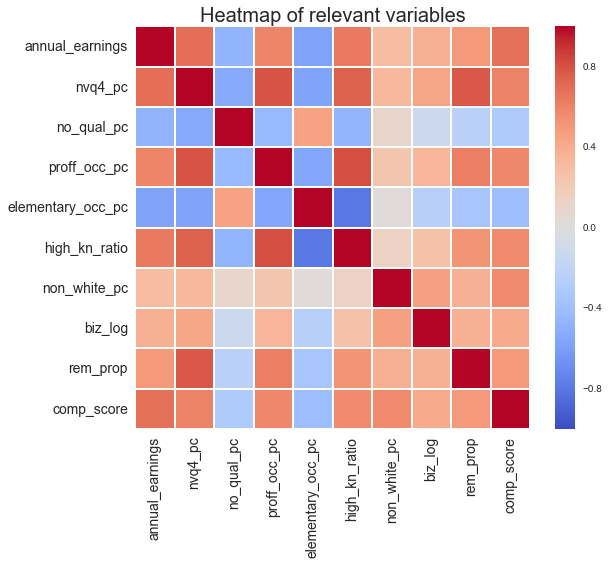

In [469]:
#Create variable of interest

my_variables = ['lad_name_x','census_total','census_white','census_non_white',
                'proff_occ_pc','elementary_occ_pc','aps_econ_rate_pc','aps_emp_rate_pc',
                'nvq4_pc','no_qual_pc',
                'Region','is_scotland',
                'biz_sum',
                'Remain','Leave','comp_score','obs_value']

#Subset interesting variables
compl_scores_ref_norm = pd.concat([compl_scores_ref2[my_variables[:-2]],
                                   compl_scores_ref2[['comp_score','obs_value']].apply(
        lambda x: scipy.stats.zscore(x))],axis=1)

#Calculate additional variables of interest
compl_scores_ref_norm['rem_prop'] = compl_scores_ref2['Remain']/compl_scores_ref2['Leave']
compl_scores_ref_norm['high_kn_ratio']=compl_scores_ref_norm[
    'proff_occ_pc']/compl_scores_ref_norm['elementary_occ_pc']
compl_scores_ref_norm['non_white_pc'] = compl_scores_ref_norm['census_non_white']/compl_scores_ref_norm['census_total']

compl_scores_ref_norm['biz_log'] = np.log(compl_scores_ref_norm['biz_sum'])

compl_scores_ref_norm.rename(columns={'obs_value':'annual_earnings',
                                     'lad_name_x':'lad_name'},inplace=True)

#Variables to correlate
corr_vars = ['annual_earnings','nvq4_pc','no_qual_pc',
             'proff_occ_pc','elementary_occ_pc','high_kn_ratio','non_white_pc','biz_log',
            'rem_prop','comp_score']

#Create heatmap
mat_heatmap = compl_scores_ref_norm[corr_vars].corr()

plt.figure(figsize=(9,8))

sns.heatmap(mat_heatmap,cmap='coolwarm',linewidths=1)
plt.title("Heatmap of relevant variables",size=20)
plt.xticks(size=14,rotation='vertical')
plt.yticks(size=14)

plt.tight_layout()
plt.savefig("outputs/econ_heatmap.pdf")

In [470]:
compl_scores_ref[['lad_name_x','Region']].to_csv('../../intermediate_outputs/lad_region_lookup.csv',index=False)

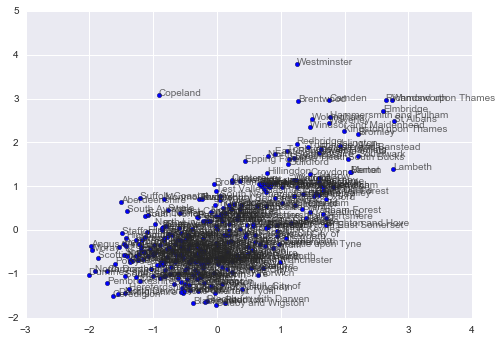

In [471]:
plt.scatter(compl_scores_ref_norm['comp_score'],compl_scores_ref_norm['annual_earnings'],
           label=[x for x in compl_scores_ref_norm['lad_name']])

labs_etc = [[s,(x,y)] for s,x,y in zip(compl_scores_ref_norm['lad_name'],
                                           compl_scores_ref_norm['comp_score'],
                                           compl_scores_ref_norm['annual_earnings'])]

for s,xy in labs_etc:
    plt.annotate(s,xy,size='small',alpha=0.7)


In [472]:
#Load rural stuff
rural_lu = pd.read_csv("../../data/Rural_Urban_Classification_2011_of_Local_Authority_Districts_in_England.csv")
#Remove the usual guff
rural_lu = rural_lu.ix[1:326,:]

In [473]:
urban_area = ['Rural' not in x for x in rural_lu.RUC11]

urban_lads = list(rural_lu.ix[urban_area,'LAD11NM'])

compl_df_engl = compl_scores_ref_norm[[
        x not in ['Scotland','Wales'] for x in compl_scores_ref_norm['Region']]]

compl_df_engl['is_urban'] = [True if x in urban_lads else False for x in compl_df_engl['lad_name']]


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


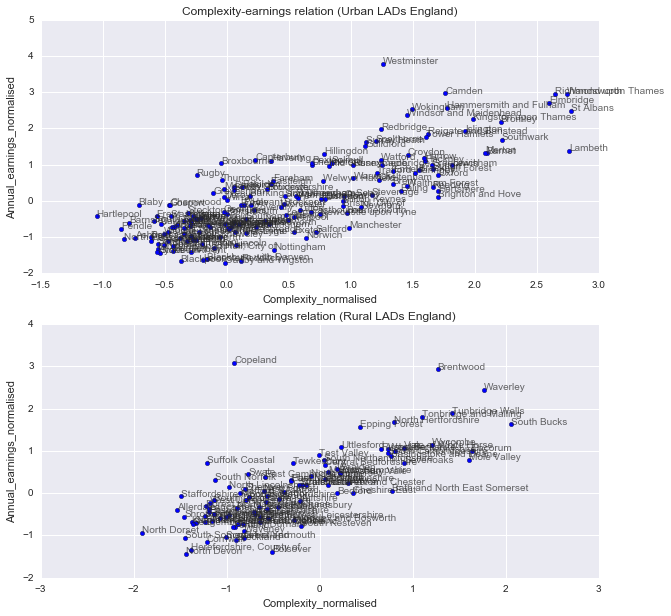

In [475]:
urban_mask = compl_df_engl['is_urban']

fig,ax=plt.subplots(figsize=(10,10))

plt.subplot(2,1,1)
plt.scatter(compl_df_engl.ix[urban_mask,'comp_score'],
            compl_df_engl.ix[urban_mask,'annual_earnings'],
           label=[x for x in compl_df_engl.ix[urban_mask,'lad_name']])
labs_etc = [[s,(x,y)] for s,x,y in zip(compl_df_engl.ix[urban_mask,'lad_name'],
                                       compl_df_engl.ix[urban_mask,'comp_score'],
                                       compl_df_engl.ix[urban_mask,'annual_earnings'])]
plt.xlabel('Complexity_normalised')
plt.ylabel('Annual_earnings_normalised')
plt.title('Complexity-earnings relation (Urban LADs England)')
for s,xy in labs_etc:
    plt.annotate(s,xy,size='small',alpha=0.7)
    
plt.subplot(2,1,2)
plt.scatter(compl_df_engl.ix[-urban_mask,'comp_score'],
            compl_df_engl.ix[-urban_mask,'annual_earnings'],
           label=[x for x in compl_df_engl.ix[-urban_mask,'lad_name']])
labs_etc = [[s,(x,y)] for s,x,y in zip(compl_df_engl.ix[-urban_mask,'lad_name'],
                                       compl_df_engl.ix[-urban_mask,'comp_score'],
                                       compl_df_engl.ix[-urban_mask,'annual_earnings'])]
for s,xy in labs_etc:
    plt.annotate(s,xy,size='small',alpha=0.7)
    
plt.xlabel('Complexity_normalised')
plt.ylabel('Annual_earnings_normalised')
plt.title('Complexity-earnings relation (Rural LADs England)')

plt.savefig("../../outputs/comp_earnings_scatter.pdf")

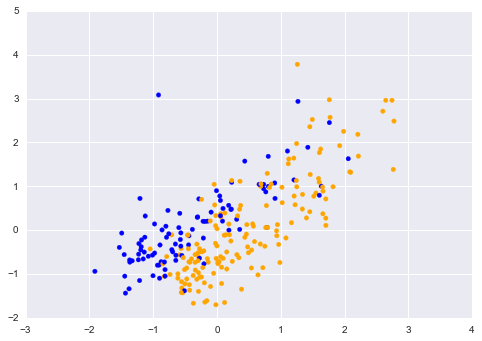

In [476]:
plt.scatter(compl_df_engl.comp_score,
            compl_df_engl.annual_earnings,
           color=['orange' if x==True else 'blue' for x in urban_mask])

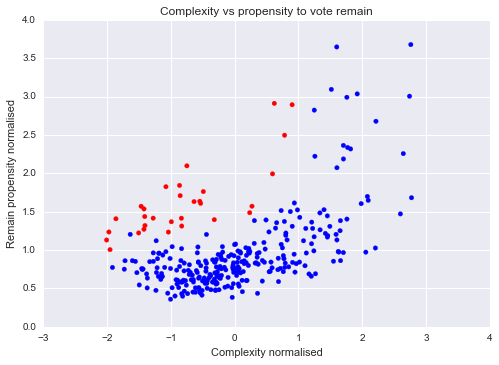

In [477]:
plt.scatter(compl_scores_ref_norm.comp_score,compl_scores_ref_norm.rem_prop,
           color=['red' if x=="Scotland" else 'blue' for x in compl_scores_ref_norm.Region])
plt.xlabel("Complexity normalised")
plt.ylabel("Remain propensity normalised")
plt.title("Complexity vs propensity to vote remain")

plt.savefig("../../outputs/comp_remain_scatter.pdf")

In [478]:
import toyplot.html, toyplot.browser,toyplot.pdf,toyplot.html

#Plot the canvas with its dimensions
canvas = toyplot.Canvas(width=600,height=500)

#Plot axes and add their labels
axes = canvas.cartesian(label="Economic complexity and average annual earnings",
                       xlabel="Economic complexity",ylabel="Average annual earnings (normalised)")

label_style = {"font-size":"8px"}

#Series to plot
x = list(compl_df_engl.comp_score)
y = list(compl_df_engl.annual_earnings)
z = list([float(x) for x in pd.qcut(compl_df_engl.rem_prop,10,labels=range(10))])
title=list(compl_df_engl.lad_name)

#Create colors based on regions
urban=list(urban_mask)
col = ["darkblue" if i ==True else "orange" for i in urban]

#Style
mstyle={"stroke":toyplot.color.near_black}

#Marking
mark = axes.scatterplot(x,y,size=6,opacity=0.6,mstyle=mstyle,
                        title=title,color=col)
axes.hlines(y=0,style={"stroke-dasharray":"2, 2"})
axes.vlines(x=0,style={"stroke-dasharray":"2, 2"})


#NB we are setting locations of y ticks explicitly to pad the legend and the title
axes.y.ticks.locator = toyplot.locator.Explicit(locations=[0,1,2])

#Legend. NB tis is a tuple with markers for the legend, and their position. The position tuple includes
    #position, inset, width and height
canvas.legend([
        ("Urban", {"shape": "o", "mstyle":{"fill":"darkblue", "stroke": toyplot.color.near_black,
                                              "opacity":0.6}}),
        ("Rural", {"shape": "o", "mstyle":{"fill":"orange", "stroke": "black",
                                                      "opacity":0.9}})],
        corner=("top-left", 50,100, 50),
             );

label_style={"font-size":"8px"}
canvas.text(550, 490, "Sources: ONS",style=label_style)

#toyplot.html.render(canvas,"outputs/chart_blog.html")

#toyplot.pdf.render(canvas,"outputs/scatter_region.pdf")

Hartlepool Middlesbrough Redcar and Cleveland Stockton-on-Tees Darlington Halton Warrington Blackburn with Darwen Blackpool Kingston upon Hull, City of East Riding of Yorkshire North East Lincolnshire North Lincolnshire York Derby Leicester Rutland Nottingham Herefordshire, County of Telford and Wrekin Stoke-on-Trent Bath and North East Somerset Bristol, City of North Somerset South Gloucestershire Plymouth Torbay Bournemouth Poole Swindon Luton Southend-on-Sea Thurrock Medway Bracknell Forest West Berkshire Reading Slough Windsor and Maidenhead Wokingham Milton Keynes Brighton and Hove Portsmouth Southampton Isle of Wight County Durham Cheshire East Cheshire West and Chester Shropshire Cornwall Wiltshire Bedford Central Bedfordshire Northumberland Aylesbury Vale South Bucks Wycombe Cambridge East Cambridgeshire Fenland Huntingdonshire South Cambridgeshire Allerdale Barrow-in-Furness Copeland South Lakeland Bolsover Chesterfield Erewash High Peak South Derbyshire Exeter North Devon North Dorset West Dorset Weymouth and Portland Eastbourne Hastings Lewes Rother Wealden Basildon Brentwood Chelmsford Colchester Epping Forest Uttlesford Cheltenham Forest of Dean Gloucester Stroud Tewkesbury Basingstoke and Deane East Hampshire Eastleigh Fareham Gosport Havant New Forest Rushmoor Test Valley Broxbourne Dacorum Hertsmere North Hertfordshire Watford Ashford Canterbury Dartford Gravesham Maidstone Sevenoaks Shepway Swale Thanet Tonbridge and Malling Tunbridge Wells Burnley Fylde Hyndburn Lancaster Pendle Preston South Ribble West Lancashire Blaby Charnwood Hinckley and Bosworth North West Leicestershire Oadby and Wigston Lincoln North Kesteven South Holland South Kesteven West Lindsey Breckland Broadland Great Yarmouth King`s Lynn and West Norfolk Norwich South Norfolk Corby East Northamptonshire Kettering Northampton South Northamptonshire Harrogate Ashfield Bassetlaw Broxtowe Gedling Rushcliffe Cherwell Oxford South Oxfordshire Vale of White Horse Mendip Sedgemoor South Somerset Taunton Deane Cannock Chase East Staffordshire Newcastle-under-Lyme South Staffordshire Stafford Staffordshire Moorlands Tamworth Babergh Ipswich St Edmundsbury Suffolk Coastal Waveney Elmbridge Guildford Mole Valley Reigate and Banstead Runnymede Spelthorne Surrey Heath Waverley Nuneaton and Bedworth Rugby Stratford-on-Avon Warwick Adur Arun Crawley Mid Sussex Redditch Worcester Wychavon Wyre Forest St Albans Welwyn Hatfield Stevenage Bolton Bury Manchester Oldham Rochdale Salford Stockport Tameside Trafford Wigan Knowsley Liverpool St. Helens Sefton Wirral Barnsley Doncaster Rotherham Sheffield Newcastle upon Tyne North Tyneside South Tyneside Sunderland Birmingham Coventry Dudley Sandwell Solihull Walsall Wolverhampton Bradford Calderdale Kirklees Leeds Wakefield Gateshead Barking and Dagenham Barnet Bexley Brent Bromley Camden Croydon Ealing Enfield Greenwich Hackney Hammersmith and Fulham Haringey Harrow Havering Hillingdon Islington Kingston upon Thames Lambeth Lewisham Merton Newham Redbridge Richmond upon Thames Southwark Sutton Tower Hamlets Waltham Forest Wandsworth Westminster -2 -1 0 1 2 3 Economic complexity 0 1 2 Average annual earnings (normalised) Economic complexity and average annual earnings Urban Rural Sources: ONS 
 
 
 Save as .csv

In [479]:
#Region boxplot
list_to_plot=[]

compl_scores_ref['compl_score_norm'] = scipy.stats.zscore(compl_scores_ref['comp_score'])

grouped_complexities = compl_scores_ref.groupby('Region')['compl_score_norm']
for i in grouped_complexities:
    list_to_plot.append(i)

list_to_plot.sort(key=lambda x: np.median(x[1]),reverse=True)

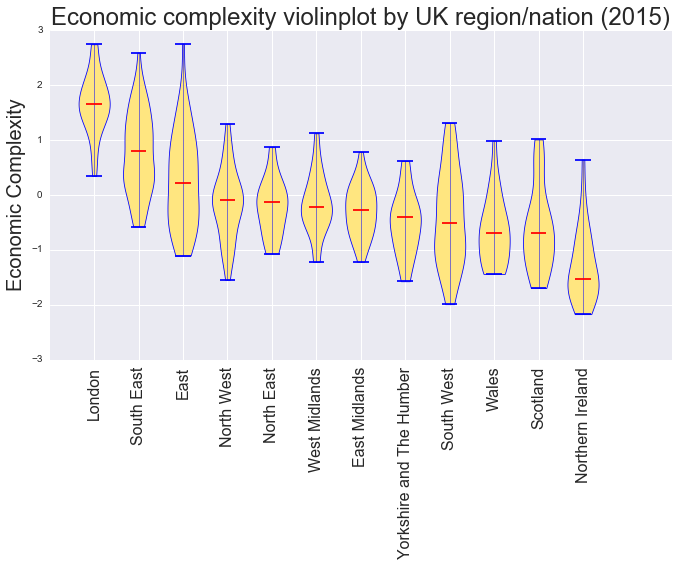

In [480]:
plt.figure(figsize=(10,8))
ax = plt.subplot(111)

bp = plt.violinplot([x[1] for x in list_to_plot],showmedians=True,widths=0.7)

plt.xticks(rotation='vertical',size=16)
ax.set_xticks(range(1,13))
ax.set_xticklabels([x[0] for x in list_to_plot])

plt.ylabel("Economic Complexity",size=20)
plt.title("Economic complexity violinplot by UK region/nation (2015)",size=24)

for box in bp['bodies']:
    box.set_linewidth(0.8)
    box.set_edgecolor('blue')
    box.set_facecolor('#ffe680')
    box.set_alpha(1)
    
plt.setp(bp['cmedians'],color='red')
plt.setp(bp['cmaxes'],color='blue')
plt.setp(bp['cmins'],color='blue')
plt.setp(bp['cbars'],color='blue',linewidth=0.5)
                      
                      
#bp.set_xticks([i for i,num in enumerate(list_to_plot)])       
#bp.set_xticklabels([x[0] for x in list_to_plot])   
plt.tight_layout()
    
plt.savefig("outputs/region_complexity_violin_2015.pdf")

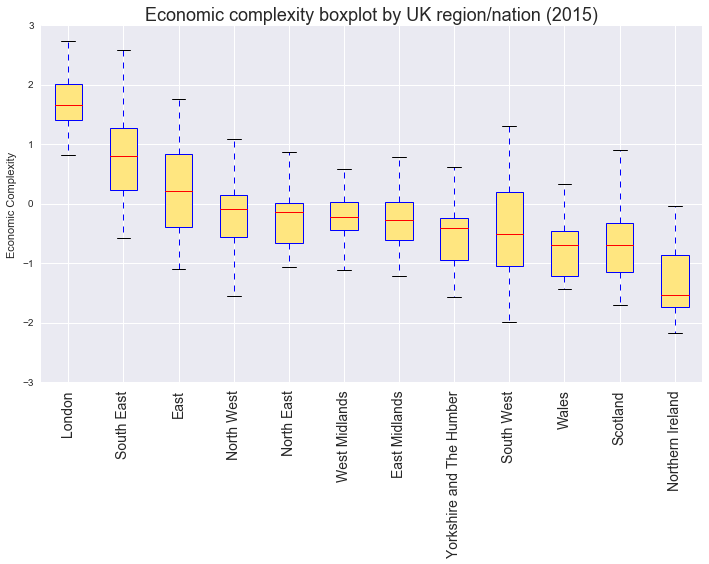

In [482]:
plt.figure(figsize=(10,8))

bp = plt.boxplot([x[1] for x in list_to_plot],labels=[x[0] for x in list_to_plot],patch_artist=True)
plt.xticks(rotation='vertical',size=14)
plt.ylabel("Economic Complexity")
plt.title("Economic complexity boxplot by UK region/nation (2015)",size=18)

for box in bp['boxes']:
    box.set_facecolor('#ffe680')
plt.tight_layout()
    
plt.savefig("outputs/region_complexity_2015.pdf")

In [483]:
#How did they vote in the European referendum - a simple contingency table?
compl_scores_ref['complex_area'] = [True if x > compl_scores_ref.compl_score_norm.quantile(q=0.75) else False for 
                               x in compl_scores_ref.compl_score_norm]

compl_scores_ref['remained'] = [True if x > 50 else False for 
                               x in compl_scores_ref.Pct_Remain]

remain_complex_ct = pd.crosstab(compl_scores_ref.complex_area,compl_scores_ref.remained)
remain_complex_ct.apply(lambda x: 100*x/x.sum(),axis=1)

remained,False,True
complex_area,,
False,83.223684,16.776316
True,35.294118,64.705882


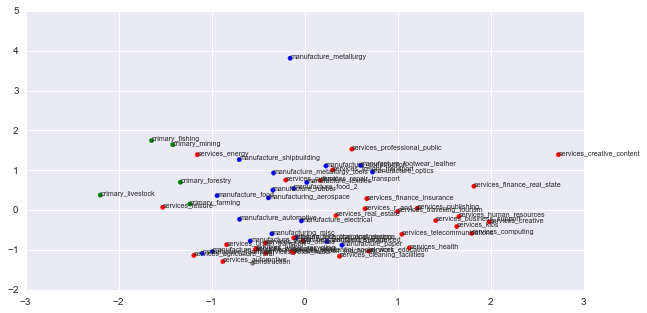

In [484]:
color_lookup = {'manufacturing':'blue',
                'manufacture':'blue',
               'primary':'green',
               'services':'red',
               'mining':'brown',
               'construction':'grey',
               'wholesale':'red'}

def get_herfindahl(x):
    '''
    Extract the herfindahl index of a vector (in shares)
    '''
    h = np.sum([val**2 for val in x])
    return(h)

#A look at industry concentration. We drop a couple of industries with very low levels of activity (less than 10
    #areas with any businesses)
sector_activity = idbr_clusters_counts.ix[:,1:].applymap(lambda x: x>0).sum(axis=0)
sectors_to_exclude = sector_activity.index[sector_activity<10]

#Create modified idbr cluster counts df
cluster_counts_selected = idbr_clusters_counts.ix[[x not in sectors_to_exclude for x in 
                                                  idbr_clusters_counts.index],
                                                  [x not in sectors_to_exclude for x in
                                                  idbr_clusters_counts.columns]]

#I will need to create and sort the shares
industry_area_shares=cluster_counts_selected.ix[:,1:]/cluster_counts_selected.ix[:,1:].sum(axis=0)
industry_area_herfs = industry_area_shares.apply(lambda x: get_herfindahl(x))

#Plot this against complexity and color with the color_lookup
industry_compl = reflections_output[15][1]
industry_compl = industry_compl[[x not in sectors_to_exclude for x in industry_compl.index]]

plt.figure(figsize=(10,5))

plt.scatter(
    scipy.stats.zscore(industry_compl),
    scipy.stats.zscore(np.log(industry_area_herfs)),
    color=[color_lookup[x.split("_")[0]] for x in industry_compl.index])

for t,x,y in zip(
    industry_compl.index,
    scipy.stats.zscore(industry_compl),
    scipy.stats.zscore(np.log(industry_area_herfs))):
             
    plt.annotate(t,(x,y),size=7)


In [485]:
#Another plot idea
#Stacked barchart with lads and regions. Color by the complexity of each industry.
#Actions: Create a slice with the share of industrial activity in each location.
#Shuffle the locations by their complexity, and their products also by their complexity.
#Create a gradient that we will use to color each slice.
#Finally, produce the stacked barchart.


#This beastie merges the df with industry shares per sector and sorts them in descending order of complexity
area_profile = pd.merge(pd.concat([idbr_clusters_counts['lad_name'],
                          idbr_clusters_counts.ix[:,1:].apply(lambda x: x/x.sum(),axis=0)],axis=1),
                        div_out.reset_index(drop=False),
                        left_on='lad_name',right_on='lad_name').sort_values(0,ascending=False).ix[:,1:-1]

#Now we want to shuffle the columns to get the more common ones at the end. We get it from the 
#vector extracted from the method of reflections algorithm.
industries_compl_sorted = industry_compl.sort_values(0,ascending=False).index

#And sort. Simples.
area_profile = area_profile[industries_compl_sorted]
area_profile.to_csv("outputs/area_profiles_for_barchart.csv",index=False)

#Now we want to create the gradient to colour the sectors

In [86]:
import statsmodels.formula.api as sm

In [538]:
#Some final transformations

compl_scores_ref_norm['nvq4_pc_norm'] = scipy.stats.zscore(compl_scores_ref_norm['nvq4_pc'])
compl_scores_ref_norm['high_kn_ratio_norm'] = scipy.stats.zscore(compl_scores_ref_norm['high_kn_ratio'])

mod = sm.ols(formula='annual_earnings~comp_score+nvq4_pc_norm+high_kn_ratio_norm+biz_log+Region',data=compl_scores_ref_norm)
res = mod.fit(cov_type='HC3')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        annual_earnings   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     34.45
Date:                Fri, 04 Nov 2016   Prob (F-statistic):           6.10e-54
Time:                        17:24:13   Log-Likelihood:                -264.70
No. Observations:                 312   AIC:                             559.4
Df Residuals:                     297   BIC:                             615.5
Df Model:                          14                                         
Covariance Type:                  HC3                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Intercept                             -0.2542      0.671     -0.379      0.705        -1.569     1.061
Region[T.East Midlands]               -0.6833      0.158     -4.316      0.000        -0.994    -0.373
Region[T.London]                       0.2602      0.198      1.311      0.190        -0.129     0.649
Region[T.North East]                  -0.6715      0.134     -5.012      0.000        -0.934    -0.409
Region[T.North West]                  -0.6473      0.186     -3.482      0.000        -1.012    -0.283
Region[T.Scotland]                    -0.3998      0.164     -2.442      0.015        -0.721    -0.079
Region[T.South East]                  -0.0199      0.152     -0.130      0.896        -0.319     0.279
Region[T.South West]                  -0.6753      0.158     -4.283      0.000        -0.984    -0.366
Region[T.Wales]                       -0.7319      0.162     -4.506      0.000        -1.050    -0.413
Region[T.West Midlands]               -0.6120      0.155     -3.936      0.000        -0.917    -0.307
Region[T.Yorkshire and The Humber]    -0.7408      0.160     -4.639      0.000        -1.054    -0.428
comp_score                             0.1699      0.058      2.928      0.003         0.056     0.284
nvq4_pc_norm                           0.2447      0.075      3.270      0.001         0.098     0.391
high_kn_ratio_norm                     0.2323      0.096      2.424      0.015         0.045     0.420
biz_log                                0.0720      0.076      0.953      0.341        -0.076     0.220
==============================================================================
Omnibus:                      119.314   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1014.083
Skew:                           1.323   Prob(JB):                    6.23e-221
Kurtosis:                      11.426   Cond. No.                         164.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

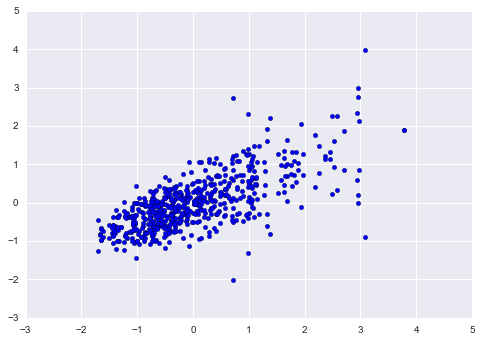

In [501]:
plt.scatter(compl_scores_ref_norm.annual_earnings,res.resid)

plt.scatter(compl_scores_ref_norm.annual_earnings,res.predict(compl_scores_ref_norm))

In [502]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

my_vars = ['comp_score','nvq4_pc_norm','high_kn_ratio_norm','biz_log']
vif_list = []

for i in range(len(my_vars)):
    res = [my_vars[i],variance_inflation_factor(np.array(compl_scores_ref_norm[my_vars]),
                                   i)]
    vif_list.append(res)
vif_list

[['comp_score', 1.6629928890081032],
 ['nvq4_pc_norm', 2.5261362143017148],
 ['high_kn_ratio_norm', 2.3473512401144956],
 ['biz_log', 1.0012121148289663]]

In [540]:
from statsmodels.iolib.summary2 import summary_col

reg0 = sm.ols(formula='annual_earnings~comp_score+biz_log+Region',
              data=compl_scores_ref_norm).fit(cov_type='HC3')
reg1 = sm.ols(formula='annual_earnings~comp_score+nvq4_pc_norm+high_kn_ratio_norm+biz_log+Region',
              data=compl_scores_ref_norm).fit(cov_type='HC3')

res_table =summary_col([reg0,reg1],stars=True,float_format='%0.2f',
     info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                             'R2':lambda x: "{:.2f}".format(x.rsquared)})
res_table.add_title("Regression results")

text_out  = res_table.as_text()

with open("outputs/reg_table.txt",'w') as file:
    file.write(text_out)

/usr/local/lib/python3.5/site-packages/statsmodels/iolib/summary2.py:372: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'
/usr/local/lib/python3.5/site-packages/statsmodels/iolib/summary2.py:374: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'
/usr/local/lib/python3.5/site-packages/statsmodels/iolib/summary2.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*

## ABS analysis

* Load ABS data and process it
* Generate GVA and employment estimates. 
* Merge with our SIC-cluster allocation, aggregate over clusters and consider change.
* Q: Which sectors do we exclude due to low levels of data?


In [88]:
#Read file
xls = pd.ExcelFile('data_input/abssectionsas.xls')

def abs_processing(excelsheet):
    '''
    Function that processes and cleans an abs excel sheet.
    It takes a timesheet and returns a clean dataframe that we can continue working with.
    '''
    abs_sections = pd.read_excel("data_input/abssectionsas.xls",sheetname=excelsheet,skiprows=9,
                             na_values=['*','..','-'])

    #Rename long and messy SIC name
    abs_sections.columns =  abs_sections.columns.str.lower()


    abs_sections.rename(columns={abs_sections.columns[0]:'sic',
                                abs_sections.columns[3]:'enterprises',
                                abs_sections.columns[4]:'turnover',
                                abs_sections.columns[5]:'agva',
                                abs_sections.columns[8]:'empl'},
                        inplace=True)

    #Approach to extraction.
    #First, forwardfill the sic field.    
    abs_sections.sic.fillna(method='pad',inplace=True)

    #Second, drop rows with NA sics
    abs_sections.dropna(subset=['sic','year'],inplace=True)

    #Select 4-digit sics and 3 years
    abs_4_digit = abs_sections[[len(x)==5 and float(y) in [2008.0,2011.0,2014.0] for x,y in zip(
                abs_sections.sic,abs_sections.year)]]

    #Select variables of interest
    abs_selected = abs_4_digit[['sic','description','year','enterprises','turnover','agva','empl']]

    #Reshape
    abs_long = pd.melt(abs_selected,id_vars=['sic','description','year'])
    
    return(abs_long)


In [89]:
#Run the function (NB need to reset the index)
abs_4_sic_long = pd.concat([abs_processing(x) for x in xls.sheet_names[1:len(xls.sheet_names)]]).reset_index(drop=True)

In [90]:
#Merge this with the lookup
abs_4_sic_long['sic_string'] = [re.sub('\.','',x) for x in abs_4_sic_long['sic']]

ind_clusters_abs = pd.merge(ind_clusters_labelled,
                           abs_4_sic_long,
                            left_on='sic_4_string',right_on='sic_string',how='outer')

#What are the overlaps
ind_sics_not_in_abs = set(ind_clusters_labelled.sic_4_string) - set(abs_4_sic_long.sic_string)
abs_sics_not_ind = set(abs_4_sic_long.sic_string) - set(ind_clusters_labelled.sic_4_string)

#We're going to have a significant problem with missing 4-digit codes in ABS. Let's run with them for now.
#I want to check, for each of the clusters, how many NA values are there.





In [91]:
#Group by cluster, variable and year, and aggregate.

#Done
ind_clusters_aggr = pd.DataFrame(ind_clusters_abs.groupby([
            'label','year','variable'])['value'].sum()).reset_index(drop=False)

#Now we want to transform the data


#Generate a labour productivity variable
ind_clusters_proc_1 = pd.pivot_table(ind_clusters_aggr,index=['label','year'],
                                     columns='variable',values='value').reset_index(drop=False)
ind_clusters_proc_1['gva_p_w'] = ind_clusters_proc_1['agva']/ind_clusters_proc_1['empl']
ind_clusters_proc_2 = pd.melt(ind_clusters_proc_1,id_vars=['label','year'])

ind_clusters_productivity = ind_clusters_proc_2.ix[
    (ind_clusters_proc_2['variable']=='gva_p_w') & (ind_clusters_proc_2['year']==2014),:]



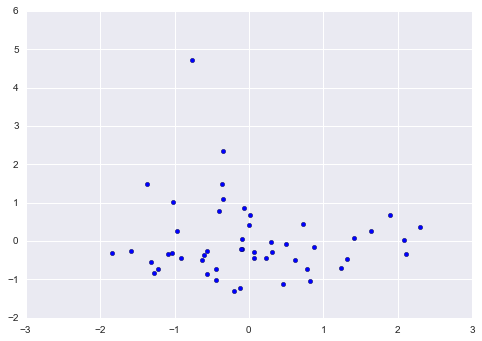

In [92]:
#What is the relationship between value added and complexity?
#What industries are the most ubiquitous?
div_inds = pd.DataFrame(reflections_output[15][1].sort_values(ascending=False)).reset_index(drop=False)

inds_prod_comp = pd.merge(div_inds,ind_clusters_productivity,left_on='index',
                         right_on='label')

inds_prod_comp.dropna(inplace=True)

#Not a clear relationship between complexity and productivity
plt.scatter(scipy.stats.zscore(inds_prod_comp[0]),
            scipy.stats.zscore(inds_prod_comp['value']))


In [93]:
#What about the relationship between complexity and growth?

def get_growth(df):
    growth_08_11 = (df.value.iloc[1]/df.value.iloc[0])-1
    growth_08_14 = (df.value.iloc[2]/df.value.iloc[0])-1
    growth_11_14 = (df.value.iloc[2]/df.value.iloc[1])-1
    return(pd.DataFrame({'g_08_11':growth_08_11,
                         'g_08_14':growth_08_14,
                         'g_11_14':growth_11_14},index=[0]))

var_growth = ind_clusters_proc_2.groupby(['label','variable']).apply(get_growth)
var_growth_proc = var_growth.reset_index(level=[0,1]).reset_index(drop=True)

gva_growth = var_growth_proc.ix[var_growth_proc['variable']=='gva_p_w',['label','g_11_14']]


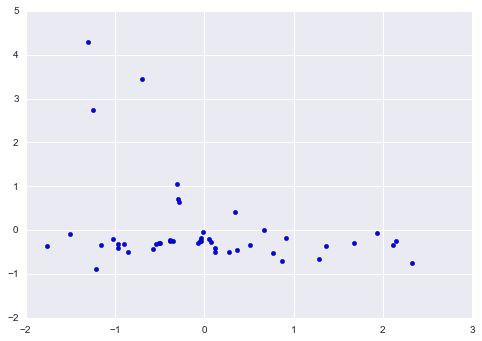

In [94]:
inds_gva_g_comp = pd.merge(div_inds,gva_growth,left_on='index',
                         right_on='label')

inds_gva_g_comp.dropna(inplace=True)

#Not a clear relationship between complexity and growth either
plt.scatter(scipy.stats.zscore(inds_gva_g_comp[0]),
            scipy.stats.zscore(inds_gva_g_comp['g_11_14']))


## Some outputs to combine with meetup data

In [95]:
compl_scores_ref.to_csv("../meetup/compl_scores.csv")
compl_df_engl.to_csv("../meetup/compl_scores_eng.csv")

## Visualising the reflections algorithm with region data

In [230]:
list(set(compl_scores_ref['Region']))

['North West',
 'East Midlands',
 'Northern Ireland',
 'East',
 'Yorkshire and The Humber',
 'West Midlands',
 'London',
 'Wales',
 'North East',
 'South East',
 'Scotland',
 'South West']

In [231]:
#Create lookup

#Allocate a colour to each region:
my_color_map = plt.get_cmap("bwr",len(set(compl_scores_ref['Region'])))


cont_list=[]
regions_sorted = ['Northern Ireland','Scotland','North East','North West','Yorkshire and The Humber',
                 'West Midlands','East Midlands','East','Wales','South West','South East','London']


for num in range(len(set(compl_scores_ref['Region']))):
    t = (regions_sorted[num],my_color_map(num))
    cont_list.append(t)
    
region_col_lookup = {el[0]:el[1] for el in cont_list}


#LAD-color lookup
lad_colour_lookup = {g:region_col_lookup[r] for g,r in zip(compl_scores_ref['geography_name'],
                                             compl_scores_ref['Region'])}

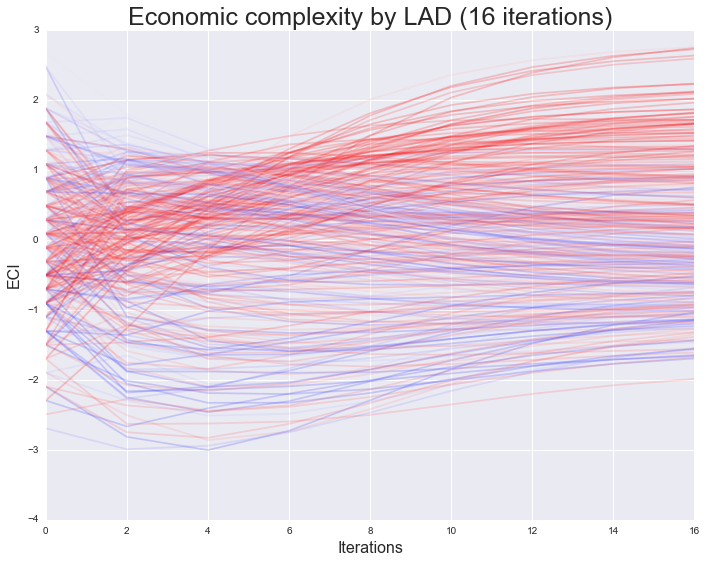

In [246]:
diversity_scores = pd.concat([pd.DataFrame(x[0],columns=[str(num)]) 
                              for num,x in enumerate(reflections_output) if num % 2==0],axis=1)
diversity_scores_norm = diversity_scores.apply(lambda x: scipy.stats.zscore(x))

plt.figure(figsize=(10,8))

for i in diversity_scores_norm.index:
    if i in region_lad_lookup.keys():
        data = diversity_scores_norm.ix[i,:]
        plt.plot(data,alpha=0.2,color=lad_colour_lookup[i])
    
plt.title("Economic complexity by LAD (16 iterations)",size=25)
plt.xlabel("Iterations",size=16)
plt.ylabel("ECI",size=16)

plt.tight_layout()

plt.savefig("outputs/complexity_graph.pdf")


In [198]:
diversity_scores_norm.ix['Braintree',:]

0     1.284743
2     0.755372
4     0.501585
6     0.310443
8     0.152692
10    0.027829
12   -0.061690
14   -0.121489
16   -0.160058
Name: Braintree, dtype: float64

In [204]:
compl_scores_ref_norm.ix[compl_scores_ref_norm['lad_name']=='Braintree',:]

,lad_name,is_scotland,Region,comp_score,obs_value,rem_prop


In [214]:
set(compl_scores_ref['geography_name'])-set(compl_scores_ref_norm['lad_name'])

{nan,
 'Castle Point',
 'Peterborough',
 'East Lindsey',
 'Lichfield',
 'Bromsgrove',
 'Dover',
 'City of London',
 'Kensington and Chelsea',
 'Harborough',
 'Melton',
 'Braintree',
 'Hounslow',
 'Harlow',
 'Hambleton',
 'Horsham',
 'Gwynedd',
 'Winchester',
 'Newark and Sherwood',
 'Rochford',
 'Cotswold',
 'Selby',
 'Worthing',
 'Tendring',
 'Forest Heath',
 'North East Derbyshire',
 'Isles of Scilly'}